# Section 1 - Define / Test Ontology Abstractions

## Ontology Superclass Definition

In [53]:
class Ontology:
    def __init__(self):
        self.entity_hierarchy = {}
        self.relationships = []

    def get_entities(self):
        """Returns the entity hierarchy in the ontology."""
        return self.entity_hierarchy
        
    def get_entities_flattened(self):
        """
        Get a flattened list of all entities from the ontology.
        """
        flattened_entities = set(self.entity_hierarchy.keys())  # Include the top-level keys
        for children in self.entity_hierarchy.values():
            flattened_entities.update(children)  # Add all child entities
        return list(flattened_entities)
        
    def get_relationships(self):
        """Returns the relationships in the ontology."""
        return self.relationships
        
    def get_relationship_dataframe(self):
        """
        Creates a DataFrame representation of all relationships in the ontology.

        Returns:
            pd.DataFrame: A DataFrame with columns for subject type, object type, and relation.
        """
        # Create a mapping table
        mapping_table = [
            {"relation": rel, "subj_type": subj, "obj_type": obj}
            for subj, obj, rel in self.get_relationships()
        ]

        # Convert to a DataFrame
        return pd.DataFrame(mapping_table)
        
    def get_triples(self):
        """Returns triples derived from relationships."""
        triples = [
            {"subject": subj, "object": obj, "relation": rel}
            for subj, obj, rel in self.relationships
        ]
        return triples

    def get_sentences_by_docid(self, docid):
        """Returns sentences by docid if supported by the ontology."""
        raise NotImplementedError("This method is not supported for this ontology.")

## TACRED Ontology Subclass Definition

In [54]:
import json
from collections import defaultdict

class TACRED(Ontology):
    def __init__(self, file_paths):
        super().__init__()
        self.file_paths = file_paths
        self.data = self.load_data()
        self.entity_hierarchy = defaultdict(set)
        self.relationships = set()
        self.sentences_by_docid = {}

        self._build_ontology()

    def load_data(self):
        """
        Load TACRED data from one or more JSON files and combine them into a single list.
        """
        combined_data = []
        for file_path in self.file_paths:
            try:
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    combined_data.extend(data)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
        return combined_data

    def _normalize_and_deduplicate_triples(self, triple):
        """
        Normalize and deduplicate triples by converting to lowercase and removing duplicates.
        """
        return {
            "subj": triple["subj"].lower(),
            "subj_type": triple["subj_type"],
            "obj": triple["obj"].lower(),
            "obj_type": triple["obj_type"],
            "relation": triple["relation"],
        }

    def _build_ontology(self):
        """
        Dynamically builds the ontology from TACRED data.
        """

        predefined_hierarchy = {
            "LOCATION": {"CITY", "COUNTRY", "STATE_OR_PROVINCE"},
            "MISC": {"TITLE"},
            "STATE": {"STATE_OR_PROVINCE"},
            "CAUSE": {"CAUSE_OF_DEATH"},
            "CRIMINAL": {"CRIMINAL_CHARGE"},
        }
    
        # Populate the entity hierarchy
        for parent, children in predefined_hierarchy.items():
            self.entity_hierarchy[parent].update(children)
    
        # Extract relationships and sentences
        for record in self.data:
            subj_type = record["subj_type"]
            obj_type = record["obj_type"]
            relation = record["relation"]
    
            # Add entities to hierarchy if not in predefined hierarchy
            if subj_type not in self.entity_hierarchy:
                self.entity_hierarchy["ROOT"].add(subj_type)
            if obj_type not in self.entity_hierarchy:
                self.entity_hierarchy["ROOT"].add(obj_type)
    
            # Add relationships
            if relation != "no_relation":
                self.relationships.add((subj_type, obj_type, relation))
    
            # Map sentences by docid
            docid = record["docid"]
            sentence = " ".join(record["token"])
            triple = self._normalize_and_deduplicate_triples({
                "subj": " ".join(record["token"][record["subj_start"]:record["subj_end"] + 1]),
                "subj_type": record["subj_type"],
                "obj": " ".join(record["token"][record["obj_start"]:record["obj_end"] + 1]),
                "obj_type": record["obj_type"],
                "relation": record["relation"],
            })
    
            # Initialize docid entry if it doesn't exist
            if docid not in self.sentences_by_docid:
                self.sentences_by_docid[docid] = {
                    "tokens": record["token"],
                    "sentence": sentence,
                    "triples": set(),  # Use a set for deduplication
                }
            
            # Add triple to the set (automatic deduplication)
            self.sentences_by_docid[docid]["triples"].add(tuple(triple.items()))  # Store as immutable tuple for set
    
        # Convert triples back to a list of dictionaries for consistency
        for docid, data in self.sentences_by_docid.items():
            data["triples"] = [dict(triple) for triple in data["triples"]]

    def get_entities(self):
        """
        Retrieve the entity hierarchy in a dictionary format.
        """
        return {parent: list(children) for parent, children in self.entity_hierarchy.items()}

    def get_relationships(self):
        """
        Retrieve the list of relationships as triples.
        """
        return list(self.relationships)

    def get_sentences_by_docid(self, docid):
        """
        Retrieve sentence and associated triples for a given docid.
        """
        return self.sentences_by_docid.get(docid, {})

    def get_all_docids(self):
        """
        Retrieve all available docids in the TACRED dataset.
        """
        return list(self.sentences_by_docid.keys())


## TACRED Ontology - Simple Usage Operations

**Important - The tacred_subpath and file paths must reference the TACRED file (e.g., test.json) you wish to process.**

In [55]:
from pprint import pprint

In [56]:
base_experiment_path = '/home/ubuntu'

tacred_subpath = '/dev'

tacred_file_paths = \
    [f"{base_experiment_path}/{tacred_subpath}/test.json"] 

In [5]:
# Load TACRED data
tacred_ontology = TACRED(tacred_file_paths)

# Retrieve entities
entities = tacred_ontology.get_entities()
print("Entities:")
pprint(entities)

Entities:
{'CAUSE': ['CAUSE_OF_DEATH'],
 'CRIMINAL': ['CRIMINAL_CHARGE'],
 'LOCATION': ['CITY', 'COUNTRY', 'STATE_OR_PROVINCE'],
 'MISC': ['TITLE'],
 'ROOT': ['URL',
          'NUMBER',
          'STATE_OR_PROVINCE',
          'IDEOLOGY',
          'ORGANIZATION',
          'CRIMINAL_CHARGE',
          'COUNTRY',
          'NATIONALITY',
          'DURATION',
          'CITY',
          'PERSON',
          'TITLE',
          'RELIGION',
          'CAUSE_OF_DEATH',
          'DATE'],
 'STATE': ['STATE_OR_PROVINCE']}


In [6]:
# Retrieve relationships
relationships = tacred_ontology.get_relationships()
print("\nRelationships:")
for rel in relationships:
    print(f"{rel[0]} -> {rel[2]} -> {rel[1]}")


Relationships:
PERSON -> per:countries_of_residence -> LOCATION
PERSON -> per:alternate_names -> MISC
ORGANIZATION -> org:website -> URL
ORGANIZATION -> org:city_of_headquarters -> LOCATION
PERSON -> per:country_of_death -> COUNTRY
PERSON -> per:other_family -> PERSON
ORGANIZATION -> org:subsidiaries -> ORGANIZATION
PERSON -> per:title -> TITLE
ORGANIZATION -> org:member_of -> COUNTRY
PERSON -> per:stateorprovince_of_birth -> STATE_OR_PROVINCE
PERSON -> per:age -> NUMBER
ORGANIZATION -> org:alternate_names -> ORGANIZATION
PERSON -> per:parents -> PERSON
PERSON -> per:country_of_birth -> NATIONALITY
PERSON -> per:spouse -> PERSON
PERSON -> per:origin -> NATIONALITY
PERSON -> per:stateorprovinces_of_residence -> STATE_OR_PROVINCE
PERSON -> per:age -> DURATION
ORGANIZATION -> org:shareholders -> PERSON
ORGANIZATION -> org:city_of_headquarters -> CITY
ORGANIZATION -> org:alternate_names -> MISC
PERSON -> per:country_of_birth -> COUNTRY
ORGANIZATION -> org:country_of_headquarters -> COUNTR

In [7]:
# Retrieve triples
triples = tacred_ontology.get_triples()
print("\nTriples:")
pprint(triples[:5])  # Print first 5 triples


Triples:
[{'object': 'LOCATION',
  'relation': 'per:countries_of_residence',
  'subject': 'PERSON'},
 {'object': 'MISC', 'relation': 'per:alternate_names', 'subject': 'PERSON'},
 {'object': 'URL', 'relation': 'org:website', 'subject': 'ORGANIZATION'},
 {'object': 'LOCATION',
  'relation': 'org:city_of_headquarters',
  'subject': 'ORGANIZATION'},
 {'object': 'COUNTRY', 'relation': 'per:country_of_death', 'subject': 'PERSON'}]


In [8]:
# Retrieve sentences by docid
docid = "APW_ENG_20100216.0150"  # Example docid
sentence = tacred_ontology.get_sentences_by_docid(docid)
print(f"\nSentence for docid {docid}:")
pprint(sentence)


Sentence for docid APW_ENG_20100216.0150:
{'sentence': 'About four years ago , he emerged in Santo Domingo saying he '
             'wanted to establish a Sephardic Jewish community .',
 'tokens': ['About',
            'four',
            'years',
            'ago',
            ',',
            'he',
            'emerged',
            'in',
            'Santo',
            'Domingo',
            'saying',
            'he',
            'wanted',
            'to',
            'establish',
            'a',
            'Sephardic',
            'Jewish',
            'community',
            '.'],
 'triples': [{'obj': 'he',
              'obj_type': 'PERSON',
              'relation': 'no_relation',
              'subj': 'his',
              'subj_type': 'PERSON'},
             {'obj': 'house',
              'obj_type': 'ORGANIZATION',
              'relation': 'no_relation',
              'subj': 'he',
              'subj_type': 'PERSON'},
             {'obj': 'new york',
              'ob

## TACRED Ontology - Simple Data Visualizations

In [9]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd

In [10]:
def plot_relation_frequencies_from_ontology(tacred_instance, include_no_relation=True):
    """
    Plots the frequency of relations in a TACRED ontology instance, 
    with the option to include or exclude 'no_relation'.
    
    Args:
        tacred_instance (TACRED): An instance of the TACRED ontology class.
        include_no_relation (bool): Whether to include 'no_relation' in the visualization.
    """
    # Access the raw TACRED data
    tacred_data = tacred_instance.data

    # Filter data based on 'include_no_relation' flag
    if not include_no_relation:
        filtered_data = [record for record in tacred_data if record["relation"] != "no_relation"]
    else:
        filtered_data = tacred_data

    # Count the frequency of each relation
    relation_counts = Counter(record["relation"] for record in filtered_data)

    # Extract relations and counts
    relations = list(relation_counts.keys())
    counts = list(relation_counts.values())

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(relations, counts)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Relation")
    plt.ylabel("Number of Records")
    plt.title("Frequency of Relations in TACRED" + (" (Excluding 'no_relation')" if not include_no_relation else ""))
    plt.show()


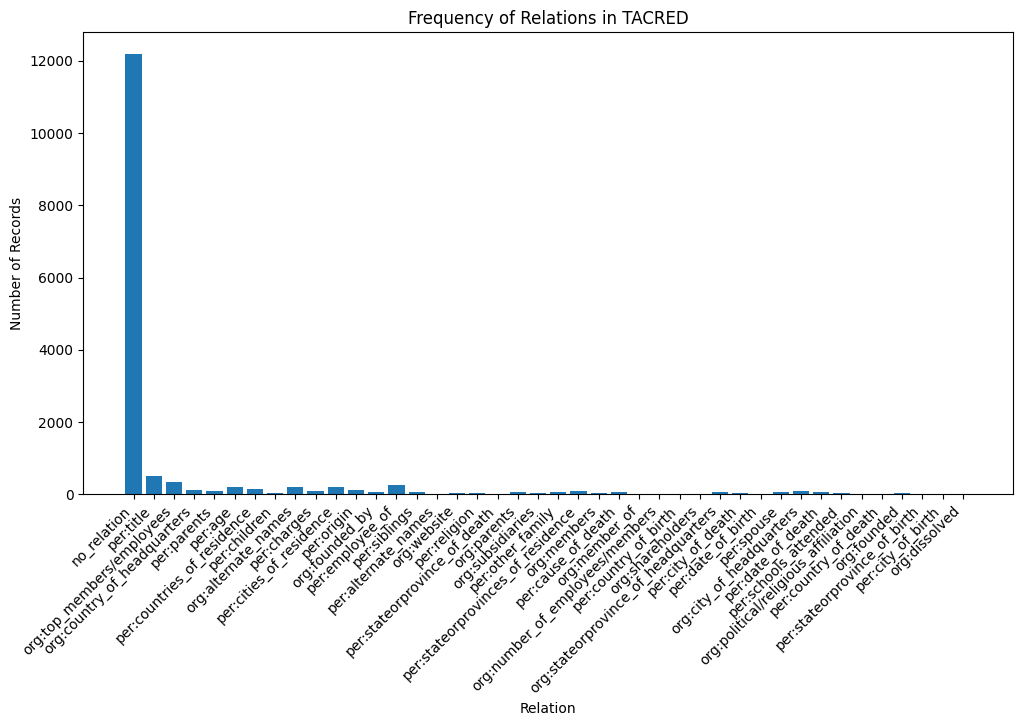

In [11]:
# Plot relation frequencies including 'no_relation'
plot_relation_frequencies_from_ontology(tacred_ontology, include_no_relation=True)

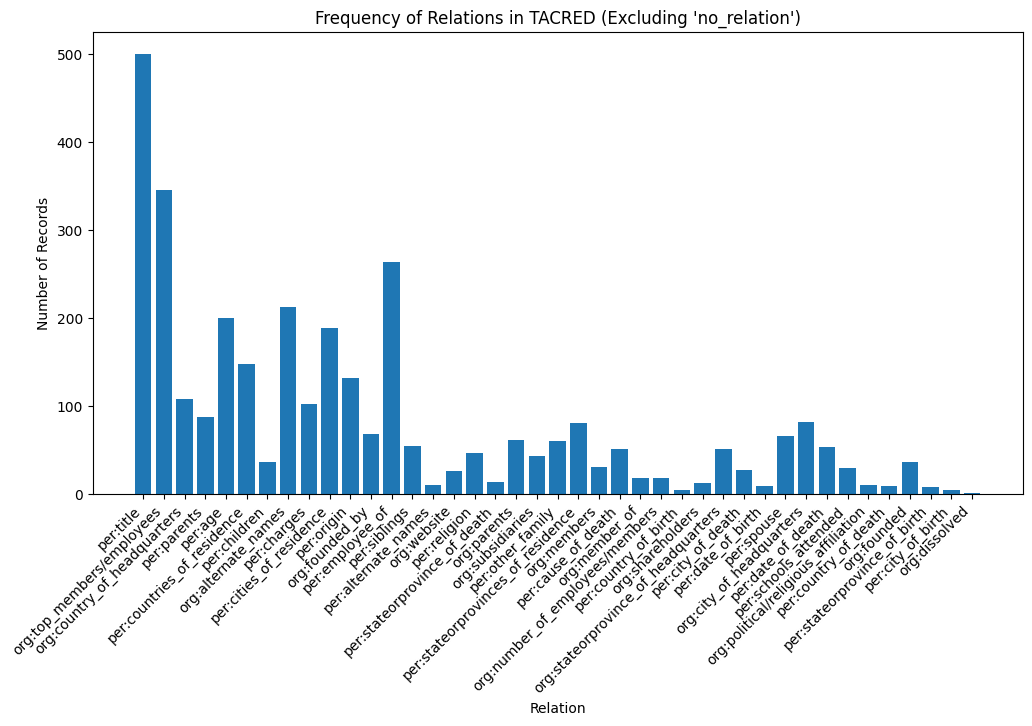

In [12]:
# Now, plot the distribution excluding no_relations, which represent the meaningful ones
plot_relation_frequencies_from_ontology(tacred_ontology, include_no_relation=False)

In [13]:
def plot_subject_object_heatmap(tacred_instance):
    """
    Generates and plots a heatmap of subject-object type relationships from TACRED data.

    Args:
        data (list): List of TACRED records.

    Returns:
        None: Displays the heatmap.
    """
    # Access the raw TACRED data
    tacred_data = tacred_instance.data
    
    # Count subject-object type pairs
    type_pairs = [(record["subj_type"], record["obj_type"]) for record in tacred_data]
    pair_counts = Counter(type_pairs)

    # Create a dataframe for heatmap
    df = pd.DataFrame.from_dict(pair_counts, orient="index", columns=["count"])
    df.reset_index(inplace=True)
    df.columns = ["pair", "count"]

    # Split the tuple 'pair' into 'subj_type' and 'obj_type'
    df[["subj_type", "obj_type"]] = pd.DataFrame(df["pair"].tolist(), index=df.index)
    df.drop(columns=["pair"], inplace=True)

    # Pivot the dataframe for heatmap format
    heatmap_data = df.pivot(index="subj_type", columns="obj_type", values="count").fillna(0).astype(int)

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar_kws={"label": "Count"})
    plt.title("Heatmap of Subject-Object Relationships")
    plt.xlabel("Object Type")
    plt.ylabel("Subject Type")
    plt.show()


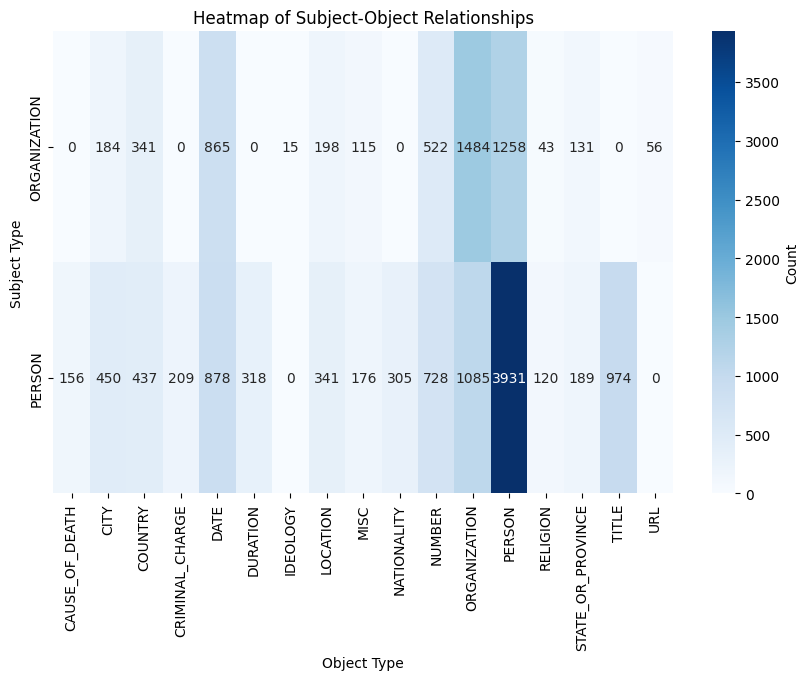

In [14]:
# Entity types within TACRED are ultimately associated with Persons or Organizations.
# Produce a heatmap showing the makeup and relative numbers of those relationships.

plot_subject_object_heatmap(tacred_ontology)

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

def create_entity_hierarchy_graph(entity_hierarchy):
    """
    Create a subgraph for the entity hierarchy with reversed edges and renamed root.

    Args:
        entity_hierarchy (dict): The entity hierarchy mapping.

    Returns:
        nx.DiGraph: A directed graph representing the reversed entity hierarchy.
    """
    G = nx.DiGraph()
    for parent, children in entity_hierarchy.items():
        parent = "Entity" if parent == "ROOT" else parent  # Rename ROOT to Entity
        G.add_node(parent)
        for child in children:
            child = "Entity" if child == "ROOT" else child  # Ensure child renaming
            G.add_node(child)
            G.add_edge(child, parent)  # Reverse the direction of the edge
    return G

def create_relationship_graph(mapping_df):
    """
    Create a subgraph for the relationships.
    
    Args:
        mapping_df (DataFrame): The mapping DataFrame containing relationships.

    Returns:
        nx.DiGraph: A directed graph representing the relationships.
    """
    G = nx.DiGraph()
    for _, row in mapping_df.iterrows():
        G.add_node(row["subj_type"])
        G.add_node(row["obj_type"])
        G.add_edge(row["subj_type"], row["obj_type"], label=row["relation"])
    return G

def visualize_subgraph(G, title="Graph Visualization", layout="kamada_kawai"):
    """
    Visualize a subgraph with a specified layout.
    
    Args:
        G (nx.DiGraph): The graph to visualize.
        title (str): Title for the visualization.
        layout (str): Layout algorithm to use ('spring', 'kamada_kawai', 'circular', etc.).
    """
    # Select layout
    if layout == "spring":
        pos = nx.spring_layout(G, seed=42)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    elif layout == "circular":
        pos = nx.circular_layout(G)
    elif layout == "shell":
        pos = nx.shell_layout(G)
    elif layout == "spectral":
        pos = nx.spectral_layout(G)
    elif layout == "random":
        pos = nx.random_layout(G)
    elif layout == "planar":
        pos = nx.planar_layout(G)
    else:
        raise ValueError(f"Unknown layout: {layout}")
        
    plt.figure(figsize=(16, 12))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="skyblue",
        node_size=3000,
        font_size=10,
        font_weight="bold",
        arrowsize=20,
    )
    edge_labels = {(u, v): d.get("label", "") for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_size=8
    )
    plt.title(title)
    plt.show()

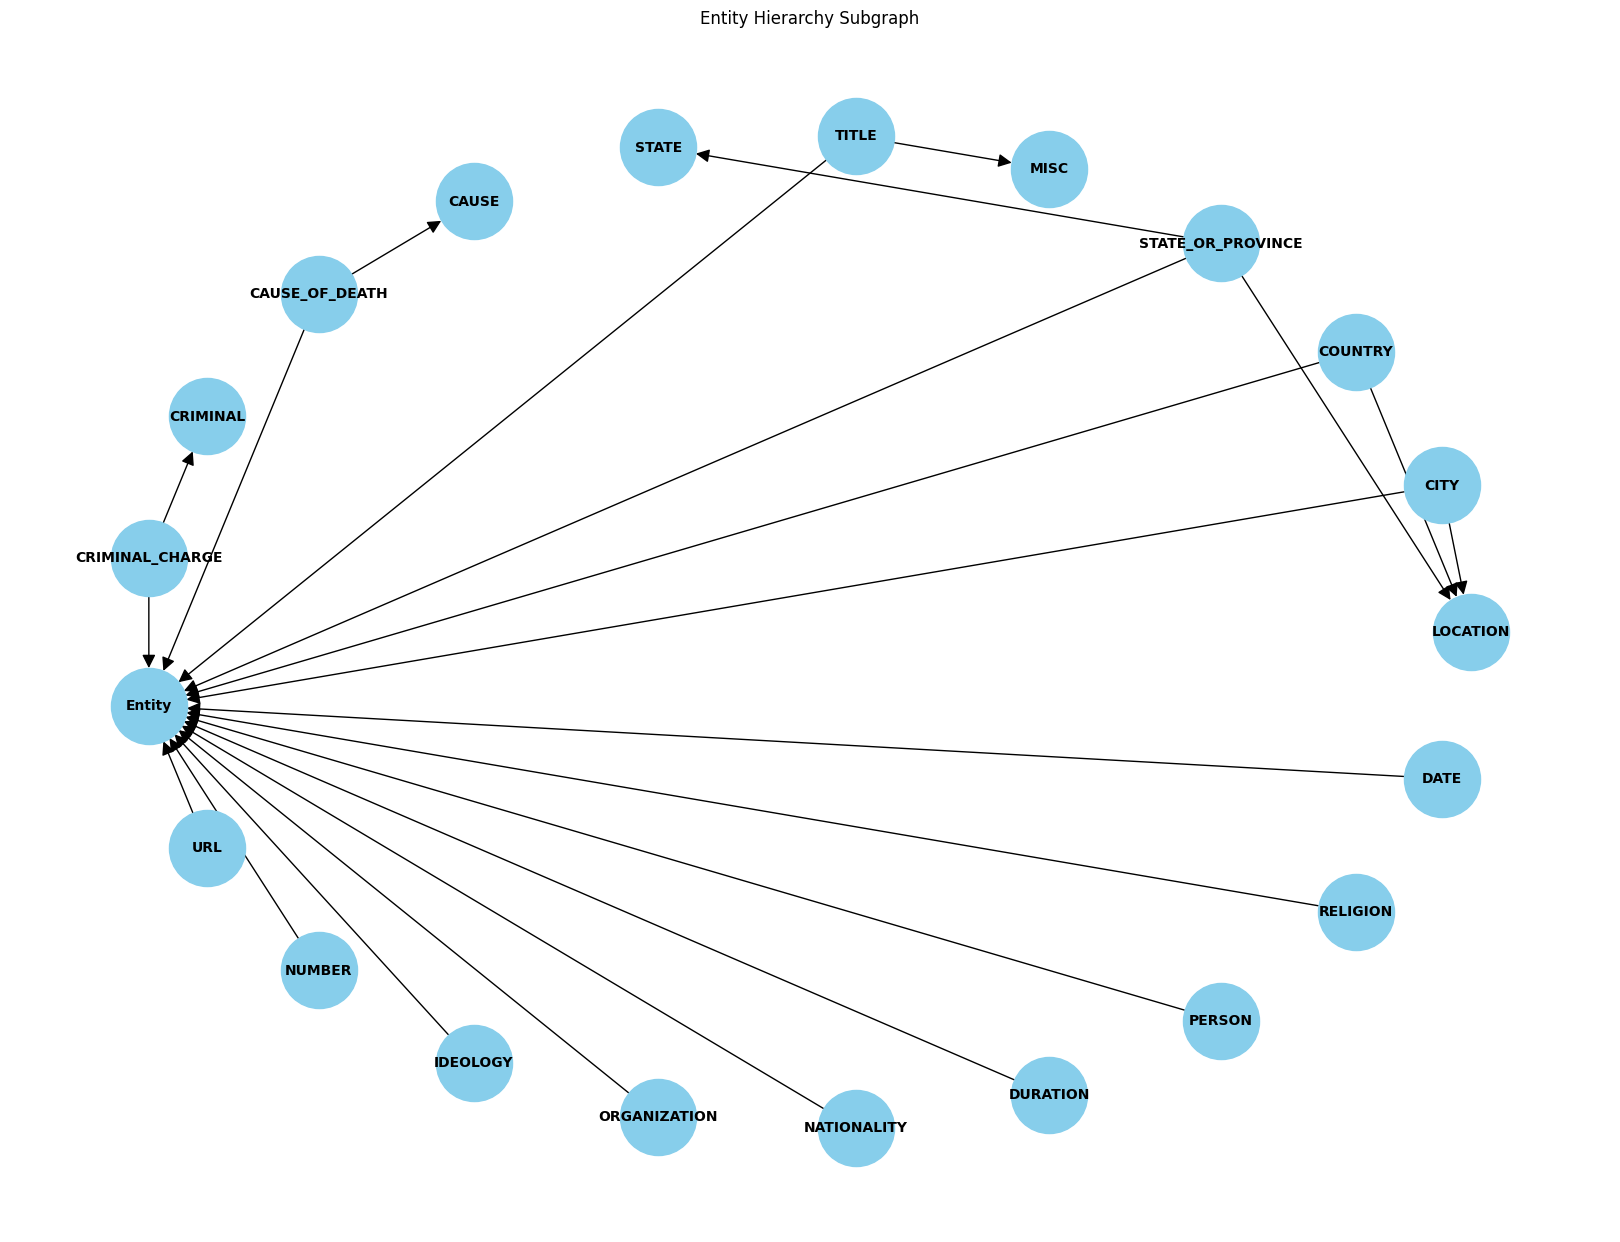

In [16]:
# Visualize Entity Hierarchy Subgraph
entity_hierarchy_graph = create_entity_hierarchy_graph(tacred_ontology.get_entities())
visualize_subgraph(entity_hierarchy_graph, title="Entity Hierarchy Subgraph", layout="circular")

In [17]:
# Generate the relationship DataFrame from the TACRED ontology instance
relationship_df = tacred_ontology.get_relationship_dataframe()

# Filter out 'no_relation' relationships if needed
filtered_relationship_df = relationship_df[relationship_df["relation"] != "no_relation"]

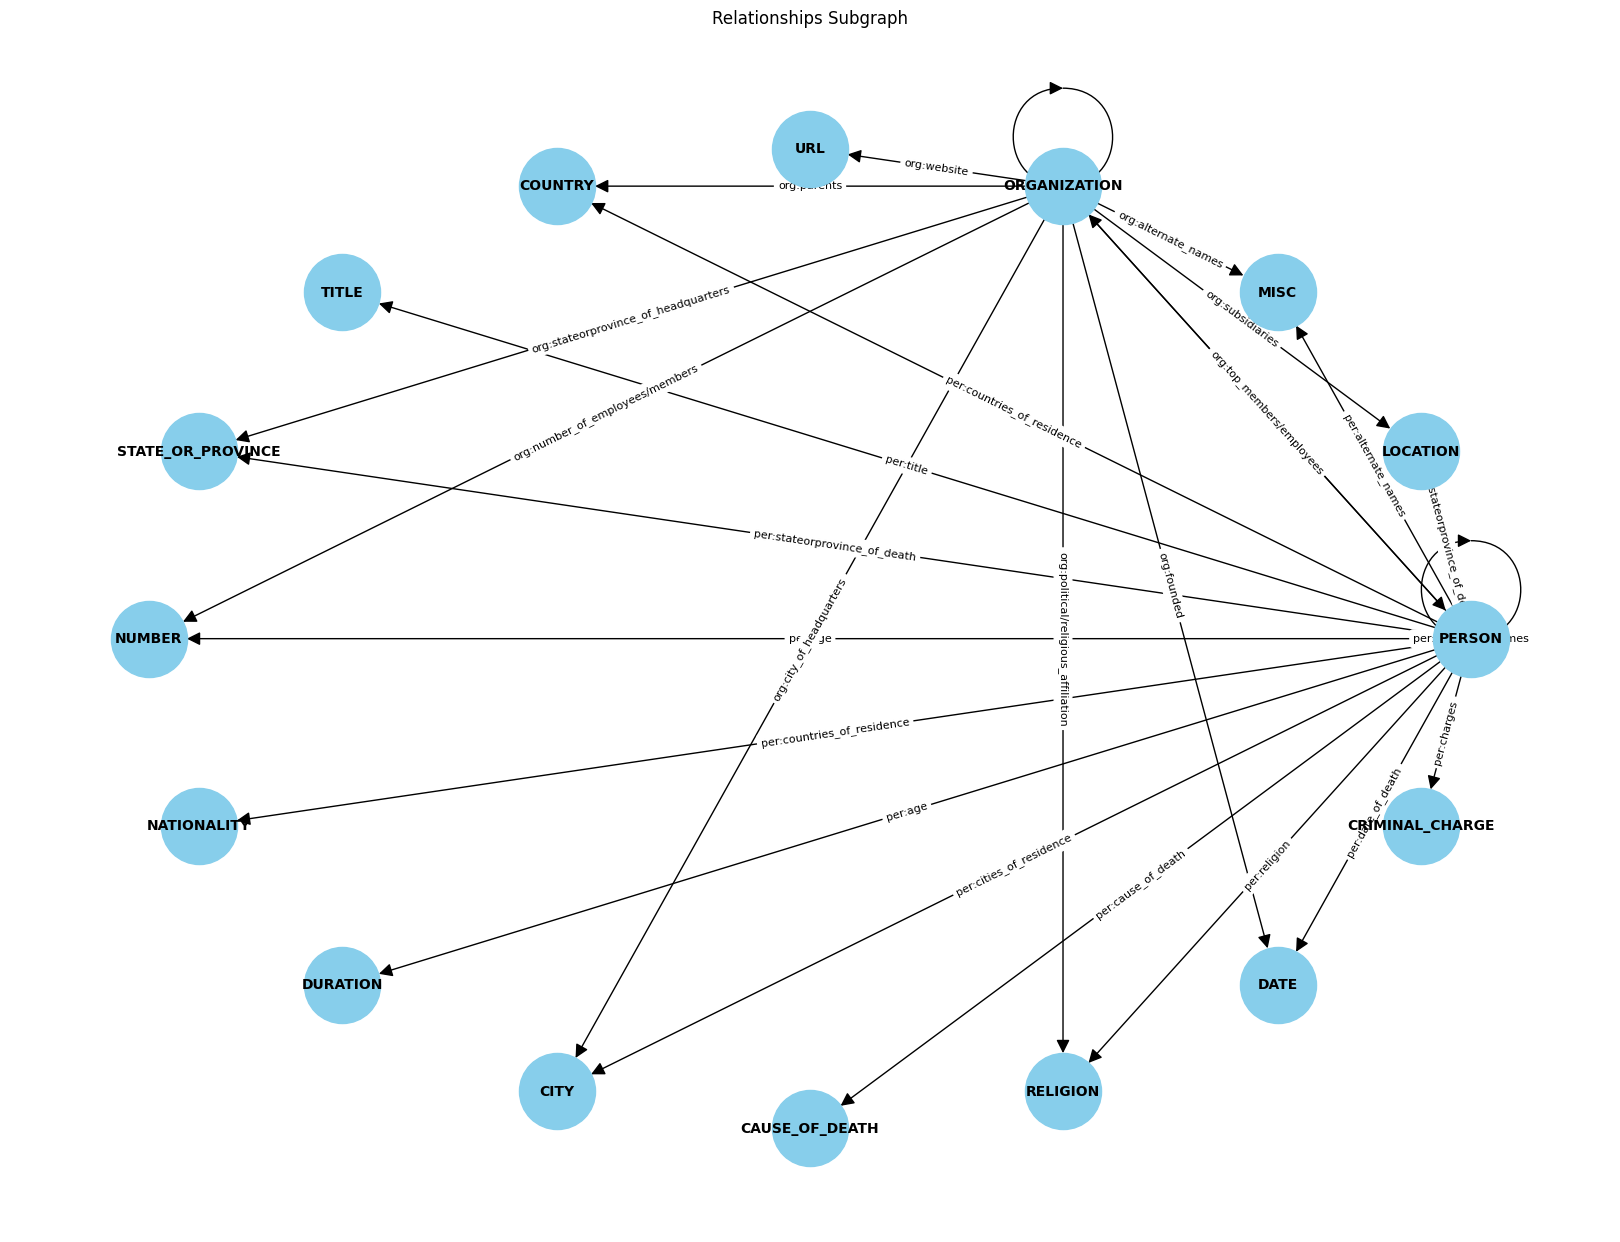

In [18]:
# Visualize Relationships Subgraph
relationship_graph = create_relationship_graph(filtered_relationship_df)
visualize_subgraph(relationship_graph, title="Relationships Subgraph", layout="circular")

# Section 2 - Define / Test Large Language Model (LLM) Abstractions

## LLM Superclass Definition

In [19]:
from abc import ABC, abstractmethod
import openai
from dotenv import load_dotenv
import os

class BaseLanguageModel(ABC):
    """
    Abstract base class for Language Models.
    """
    @abstractmethod
    def __init__(self, **kwargs):
        pass

    @abstractmethod
    def initialize(self):
        """
        Abstract method to handle initialization of the language model (e.g., loading API keys).
        """
        pass

    @abstractmethod
    def prompt(self, prompt_template: str, sentence: str, **kwargs) -> str:
        """
        Sends a prompt to the language model and retrieves a response.
        """
        pass

## OpenAI Subclass Definition

In [20]:
from openai import OpenAI

class OpenAIModel(BaseLanguageModel):
    """
    Implementation for OpenAI GPT models.
    """
    def __init__(self, model: str = "gpt-4", max_tokens: int = 1500, temperature: float = 0.2):
        """
        Initialize the OpenAI model parameters.
        """
        self.model = model
        self.max_tokens = max_tokens
        self.temperature = temperature
        self.initialize()  # Explicitly call initialize during instantiation

    def initialize(self):
        """
        Load OpenAI API key and validate it.
        """
        load_dotenv()
        openai_api_key = os.getenv("OPENAI_API_KEY")
        openai.api_key = openai_api_key

        if openai_api_key is None:
            raise ValueError("OpenAI API key not found in the .env file.")
        
        print("OpenAI API key loaded successfully!")

    def prompt(self, prompt_template: str, sentence: str, **kwargs) -> str:
        """
        Sends a prompt to the OpenAI GPT model.
        """
        try:
            messages = [
                {"role": "system", "content": prompt_template},
                {"role": "user", "content": sentence}
            ]

            client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))
            
            # Allow overriding model parameters
            response = client.chat.completions.create(
                model=kwargs.get("model", self.model),
                messages=messages,
                max_tokens=kwargs.get("max_tokens", self.max_tokens),
                temperature=kwargs.get("temperature", self.temperature),
            )

            # Extract the generated solution from the response
            final_response = response.choices[0].message.content.strip()
            return final_response
        except Exception as e:
            print(f"Error generating solution: {e}")
            return None

## Meta Llama Subclass Definition

In [21]:
from llama_stack_client import LlamaStackClient

class LlamaModel(BaseLanguageModel):
    """
    Implementation for LLaMA models using LlamaStackClient API.
    """
    def __init__(self, base_url: str, model_id: str, temperature: float = 0.6, \
        top_p: float = 0.9, max_tokens = 256, max_seq_length = 8192, **kwargs):
        """
        Initialize the LLaMA model client.
        
        Args:
            base_url (str): The LlamaStack server endpoint.
            model_id (str): The unique identifier for the model to query.
            temperature (float): Sampling temperature.
            top_p (float): Nucleus sampling top-p value.
        """
        self.base_url = base_url
        self.model_id = model_id
        self.temperature = temperature
        self.top_p = top_p
        self.max_tokens = max_tokens
        self.max_seq_length = max_seq_length
        self.client = None
        self.initialize()

    def initialize(self):
        """
        Initialize the LlamaStack client.
        """
        try:
            # Create a client to communicate with the LlamaStack server
            self.client = LlamaStackClient(base_url=self.base_url)
            print(f"LlamaStackClient initialized with endpoint: {self.base_url}")
        except Exception as e:
            raise ValueError(f"Failed to initialize LlamaStackClient: {e}")

    def prompt(self, prompt_template: str, sentence: str, **kwargs) -> str:
        """
        Sends a prompt to the LLaMA model and returns the response.
        
        Args:
            prompt_template (str): The template or system message for the model.
            sentence (str): The user query or input.

        Returns:
            str: The generated response from the model.
        """
        try:
            # Construct the conversation messages
            messages = []
            if prompt_template:
                messages.append({"role": "system", "content": prompt_template})
            messages.append({"role": "user", "content": sentence})

            # Calculate remaining tokens for response
            prompt_token_length = sum(len(m["content"].split()) for m in messages)  # Approximate token count
            max_response_tokens = min(self.max_seq_length - prompt_token_length, self.max_tokens)

            # Call the LlamaStack API for chat completion
            result = self.client.inference.chat_completion(
                model_id=self.model_id,
                messages=messages,
                sampling_params={
                    "temperature": kwargs.get("temperature", self.temperature),
                    "top_p": kwargs.get("top_p", self.top_p),
                    "max_tokens": kwargs.get("max_tokens", self.max_tokens),
                },
                stream=False
            )

            # Extract and return the generated response
            response = result.completion_message.content
            return response
        except Exception as e:
            print(f"Error generating solution via LlamaStack API: {e}")
            return None

# Section 3 - Define / Test Ontology Mapping and Prompt Generation Abstractions

In [22]:
from sentence_transformers import SentenceTransformer, util
import spacy

class OntologyMapper:
    def __init__(self, ontology, spacy_model="en_core_web_sm", similarity_model="all-MiniLM-L6-v2", verbose=False):
        self.ontology = ontology
        self.spacy_model = spacy_model
        self.nlp = spacy.load(spacy_model)
        self.similarity_model = SentenceTransformer(similarity_model)
        self.verbose = verbose        
        self.spacy_to_ontology_map = self.generate_semantic_similarity_map()

    def generate_semantic_similarity_map(self):
        ontology_entity_types = self.ontology.get_entities_flattened()
        spacy_types = [
            "PERSON", "ORG", "LOC", "GPE", "DATE", "TIME", "NORP", \
            "QUANTITY", "PERCENT", "FAC", "CARDINAL", "ORDINAL", "MONEY", \
            "LANGUAGE", "LAW", "WORK_OF_ART", "EVENT", "PRODUCT"
        ]
        
        # Encode types using SentenceTransformer
        spacy_embeddings = self.similarity_model.encode(spacy_types, convert_to_tensor=True)
        ontology_embeddings = self.similarity_model.encode(ontology_entity_types, convert_to_tensor=True)
        similarity_matrix = util.pytorch_cos_sim(spacy_embeddings, ontology_embeddings)

        spacy_to_ontology_map = {}
        for i, spacy_type in enumerate(spacy_types):
            similarities = similarity_matrix[i]
            max_similarity_index = similarities.argmax().item()
            max_similarity_score = similarities[max_similarity_index].item()
            most_probable_mapping = ontology_entity_types[max_similarity_index]
            spacy_to_ontology_map[spacy_type] = {
                "type": most_probable_mapping,
                "score": max_similarity_score
            }

        # Debug: Print the entire mapping
        if self.verbose:
            print("Generated Spacy to Ontology Mappings:")
            for spacy_type, mapping in spacy_to_ontology_map.items():
                print(f"{spacy_type} -> {mapping}")
        
        return spacy_to_ontology_map

    def map_spacy_ner_to_ontology(self, sentence):
        doc = self.nlp(sentence)
        mapped_types = {}
        unmapped_entities = []

        # Debug: Print Spacy NER results
        if self.verbose:
            print("Spacy NER Results:")
        for ent in doc.ents:
            if self.verbose:
                print(f"Text: {ent.text}, Label: {ent.label_}")

        for ent in doc.ents:
            spacy_type = ent.label_
            mapping = self.spacy_to_ontology_map.get(spacy_type)

            # Debug: Print mapping details
            if self.verbose:
                print(f"Mapping for '{ent.text}' ({spacy_type}): {mapping}")

            if mapping:
                mapped_types[ent.text] = mapping
            else:
                unmapped_entities.append(ent.text)
                mapped_types[ent.text] = {"type": None, "score": None}

        if unmapped_entities:
            print(f"Warning: The following entities could not be mapped to the ontology: {unmapped_entities}")

        return mapped_types, doc

In [23]:
import json
import random
from sentence_transformers import SentenceTransformer, util
import networkx as nx

class PromptGenerator:
    def __init__(self, ontology, language_model, spacy_model="en_core_web_sm",
                 predefined_examples_path="predefined_examples.json", semantic_model_name="all-MiniLM-L6-v2",
                    max_entities="all", max_relationships="all"):
        """
        Initialize the PromptGenerator.
        Args:
            ontology: An instance of the Ontology class.
            language_model: An instance of the BaseLanguageModel subclass.
            spacy_model (str): The spaCy model to use for NER.
            predefined_examples_path (str): Path to the predefined examples JSON file.
            semantic_model_name (str): Name of the SentenceTransformer model for semantic similarity.
        """
        self.ontology = ontology
        self.language_model = language_model
        self.mapper = OntologyMapper(ontology, spacy_model)
        self.max_entities = max_entities
        self.max_relationships = max_relationships

        # Load predefined examples once during initialization
        with open(predefined_examples_path, 'r') as file:
            self.predefined_examples = json.load(file)

        # Load the semantic model
        self.semantic_model = SentenceTransformer(semantic_model_name)

    def extract_relevant_ontology(self, sentence, top_k=10):
        """
        Extract relevant ontology information (entities and relationships) based on the input sentence.
        """
        mapped_types, doc = self.mapper.map_spacy_ner_to_ontology(sentence)
        ontology_entity_types = {value.get("type") for value in mapped_types.values() if value}

        # Filter ontology relationships by mapped entity types
        candidate_relationships = [
            (subj, obj, rel) for subj, obj, rel in self.ontology.get_relationships()
            if subj in ontology_entity_types and obj in ontology_entity_types
        ]

        # Rank relationships based on semantic similarity
        ranked_relationships = self.rank_relationships(doc, mapped_types, candidate_relationships, top_k)

        return {
            "entity_types": ontology_entity_types,
            "relationships": ranked_relationships
        }

    def rank_relationships(self, doc, mapped_types, candidate_relationships, top_k=10, max_linking_text_length=10):
        import networkx as nx
    
        print("\n--- Debugging Relationship Ranking ---\n")
        print(f"Input Sentence: {doc.text}")
        print(f"Candidate Relationships: {candidate_relationships}")
        print(f"Mapped Types: {mapped_types}\n")
    
        # Build dependency graph
        graph = nx.DiGraph()
        for token in doc:
            graph.add_edge(token.head, token)
            graph.add_edge(token, token.head)  # Add bidirectional edges
            print(f"Edge Added to Graph: ({token.head.text} -> {token.text})")
    
        semantic_scores = []
        for subj, obj, rel in candidate_relationships:
            print(f"\nEvaluating Candidate: Subject={subj}, Object={obj}, Relationship={rel}")
    
            # Find entities of the given types
            subj_entities = [ent for ent in doc.ents if mapped_types.get(ent.text, {}).get("type") == subj]
            obj_entities = [ent for ent in doc.ents if mapped_types.get(ent.text, {}).get("type") == obj]
            print(f"  Subject Entities: {[ent.text for ent in subj_entities]}")
            print(f"  Object Entities: {[ent.text for ent in obj_entities]}")
    
            for subj_ent in subj_entities:
                for obj_ent in obj_entities:
                    if subj == obj:
                        print(f"  Reflexive Relationship Skipped: {subj} -> {obj}")
                        continue  # Skip reflexive relationships
    
                    try:
                        if nx.has_path(graph, subj_ent.root, obj_ent.root):
                            path = nx.shortest_path(graph, source=subj_ent.root, target=obj_ent.root)
                            if len(path) > max_linking_text_length:
                                print(f"  Skipping Path (Too Long): {[token.text for token in path]}")
                                continue
    
                            linking_text = " ".join(token.text for token in path)
                            print(f"  Linking Text: {linking_text}")
                            path_length_score = 1 / len(path)
                            print(f"  Path Length Score: {path_length_score}")
    
                            # Verb relevance
                            verbs_in_path = [token.lemma_ for token in path if token.pos_ == "VERB"]
                            verb_relevance = 1 if verbs_in_path else 0.5  # Default verb relevance
                            print(f"  Verbs in Path: {verbs_in_path}, Verb Relevance: {verb_relevance}")
                        else:
                            print(f"  No Path Found for {subj} -> {obj}, using sentence context.")
                            linking_text = f"{subj_ent.text} ... {obj_ent.text}"
                            path_length_score = 0.1
                            verb_relevance = 0.1
                            similarity_score = self.semantic_model.similarity(subj_ent.text, obj_ent.text)
                            final_score = similarity_score + path_length_score * verb_relevance
                            semantic_scores.append((final_score, (subj, obj, rel, linking_text)))
                            continue
    
                        # Semantic similarity
                        linking_text_embedding = self.semantic_model.encode(linking_text, convert_to_tensor=True)
                        relationship_embedding = self.semantic_model.encode(rel, convert_to_tensor=True)
                        similarity_score = util.pytorch_cos_sim(linking_text_embedding, relationship_embedding).item()
                        print(f"  Similarity Score: {similarity_score}")
    
                        final_score = similarity_score + path_length_score * verb_relevance
                        print(f"  Final Score: {final_score}")
    
                        semantic_scores.append((final_score, (subj, obj, rel, linking_text)))
                    except Exception as e:
                        print(f"  Error processing {subj} -> {obj}: {e}")
                        continue
    
        sorted_relationships = sorted(semantic_scores, key=lambda x: x[0], reverse=True)
        print("\nSorted Relationships (Debug):")
        for score, details in sorted_relationships:
            print(f"  Score: {score}, Details: {details}")
    
        unique_relationships = {}
        for score, (subj, obj, rel, linking_text) in sorted_relationships:
            if score > 0.0 and linking_text:
                unique_relationships[(subj, obj, rel)] = (score, linking_text)
    
        print("\nUnique Relationships (Filtered):")
        for key, value in unique_relationships.items():
            print(f"  Key: {key}, Value: {value}")
    
        result = [
            (subj, obj, rel, linking_text, score)
            for (subj, obj, rel), (score, linking_text) in unique_relationships.items()
        ][:top_k]
    
        print("\nFinal Ranked Relationships:")
        for r in result:
            print(f"  {r}")
        print("\n--- End of Debugging ---\n")
    
        return result

    def generate_ontology_guided_prompt(self, sentence):
        """
        Generate an ontology-guided prompt.
        """
        entity_list = list(self.ontology.get_entities_flattened())  # Use get_entities
        relationship_list = self.ontology.get_relationships()    # Use get_relationships

        return f"""
You are an expert information extraction system. Your task is to identify entities and relationships
in the given sentence following a structured format and based on the provided ontology.

### Ontology for Entity and Relationship Extraction:
- Entity Types: {', '.join(entity_list)}
- Relationship Types: {', '.join([f'{subj} -> {rel} -> {obj}' for subj, obj, rel in relationship_list])}

### Instructions:
1. Extract {self.max_entities} **entities** from the text and classify them according to the ontology above.
2. Extract {self.max_relationships} **relationships** between entities as defined in the ontology above. Any deviation is an error.
3. Output ONLY the JSON object. Do not add explanations, headers, or formatting markers like ```json. If the JSON becomes too long, 
ensure all arrays and objects are valid and complete.
4. Return the output in the following strict JSON format:

Please Output in the following JSON format:
{{
  "sentence": "The input sentence",
  "entities": [
    {{"type": "EntityType1", "text": "Entity1"}},
    {{"type": "EntityType2", "text": "Entity2"}}    
  ],  
  "relationships": [
    {{"type": "RelationshipType1", "subject": "Entity1", "object": "Entity2"}},
    {{"type": "RelationshipType2", "subject": "Entity1", "object": "Entity2"}}       
  ]
}}
"""

    def generate_few_shot_prompt(self, sentence, num_examples=3):
        """
        Generate a few-shot prompt using predefined examples, guided by ranked relationships.
        """
        relevant_ontology = self.extract_relevant_ontology(sentence)
        entity_types = relevant_ontology["entity_types"]
        relationships = relevant_ontology["relationships"]
    
        # Filter examples based on the most relevant relationships
        examples = self.select_relevant_predefined_examples(self.predefined_examples, relationships, num_examples)
    
        return f"""
    Ontology Context:
    - Entity Types: {', '.join(entity_types)}
    - Relationship Types: {', '.join([f'{subj} -> {rel} -> {obj}' for subj, obj, rel, _, _ in relationships])}
    
    Here are examples of extractions:
    {json.dumps(examples, indent=2)}
    
    Extract entities and relationships from the following sentence:
    "{sentence}"
    
    Output in JSON format:
    {{
      "sentence": "The input sentence",
      "entities": [
        {{"type": "EntityType1", "text": "Entity1"}},
        {{"type": "EntityType2", "text": "Entity2"}}
      ],
      "relationships": [
        {{"type": "RelationshipType1", "subject": "Entity1", "object": "Entity2"}},
        {{"type": "RelationshipType2", "subject": "Entity1", "object": "Entity2"}}        
      ]
    }}
    """

    def generate_chain_of_thought_prompt(self, sentence):
        """
        Generate a chain-of-thought prompt.
        """
        entity_list = list(self.ontology.get_entities_flattened())  # Use get_entities
        relationship_list = self.ontology.get_relationships()    # Use get_relationships

        return f"""
You are an expert information extraction system. Your task is to extract entities 
and relationships from the provided sentence based on the given ontology. 
Generate valid JSON output only, with no explanations or reasoning. 

Follow this structure strictly:
{{
  "sentence": "The input sentence",
  "entities": [
    {{"type": "EntityType1", "text": "EntityValue1"}}
  ],
  "relationships": [
    {{"type": "RelationshipType1", "subject": "EntityValue1", "object": "EntityValue2"}},
    {{"type": "RelationshipType2", "subject": "EntityValue1", "object": "EntityValue2"}} 
  ]
}}

### Ontology for Entity and Relationship Extraction:  
- Entity Types: {', '.join(entity_list)}
- Relationship Types: {', '.join([f'{subj} -> {rel} -> {obj}' for subj, obj, rel in relationship_list])}

"""

    def generate_json_guided_prompt(self, sentence):
        """
        Generate a JSON-guided prompt.
        """
        return f"""
Extract entities and relationships from the following sentence:
"{sentence}"

Follow this schema:
{{
  "sentence": "The input sentence",
  "entities": [
    {{"type": "EntityType1", "text": "Entity1"}}
  ],
  "relationships": [
    {{"type": "RelationshipType", "subject": "Entity1", "object": "Entity2"}}
  ]
}}
"""

    def select_relevant_predefined_examples(self, predefined_examples, relationships, num_examples=3):
        """
        Select relevant examples from predefined examples based on the relationships.
        """
        relevant_examples = []

        for subj, obj, rel, *rest in relationships:
            key = f"{subj}<-{rel}->{obj}"
            if key in predefined_examples:
                examples = predefined_examples[key]
                selected_examples = random.sample(examples, min(num_examples, len(examples)))
                relevant_examples.extend(selected_examples)

        return relevant_examples

    def generate_prompt(self, strategy, sentence, num_examples=1):
        """
        Generate a prompt based on the selected strategy.
        """
        if strategy == "ontology":
            return self.generate_ontology_guided_prompt(sentence)
        elif strategy == "few_shot":
            return self.generate_few_shot_prompt(sentence, num_examples)
        elif strategy == "chain_of_thought":
            return self.generate_chain_of_thought_prompt(sentence)
        elif strategy == "json_guided":
            return self.generate_json_guided_prompt(sentence)
        else:
            raise ValueError("Invalid strategy selected.")

# Section 4 - Evaluate LLM Named-Entity (NER) and Relationship Extration (RE) Performance Against TACRED Ground Thruth

In [24]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from collections import defaultdict
from partial_json_parser import ensure_json
from datetime import datetime
import pandas as pd
import json
import string
import time
import re

class LLMEvaluator:
    """
    Modular runner to evaluate one LLM against ground truth.
    """
    def __init__(self, name, prompt_strategy, ontology, model, prompt_generator):
        """
        Initialize the LLM Runner.
        
        Args:
            name (str): Name of the LLM for tracking (e.g., "OpenAI", "LLaMA").
            ontology (Ontology): Ontology instance (e.g., TACRED).
            model (BaseLanguageModel): LLM instance to evaluate.
            prompt_generator (PromptGenerator): Instance for generating prompts.
        """
        self.name = name
        self.ontology = ontology
        self.model = model
        self.prompt_generator = prompt_generator
        self.prompt_strategy = prompt_strategy
        self.results = []

        self.allowed_entities = self.ontology.get_entities_flattened()
        self.allowed_relationships = set(rel for _, _, rel in self.ontology.get_relationships())
        self.sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

    def normalize_text(self, text):
        """
        Normalize text by stripping spaces, converting to lowercase, and removing punctuation.
        """
        new_text = text.lower().translate(str.maketrans("", "", string.punctuation)).strip()
        return new_text
        
    def parse_relationship(self, relationship_str):
        """
        Parse a relationship string into a tuple (subject, relationship, object).
    
        Args:
            relationship_str (str): Relationship string in the format "subject -> relation -> object".
    
        Returns:
            tuple: Parsed (subject, relation, object) components.
        """
        parts = [part.strip() for part in relationship_str.split("->")]

        # Case 1: No '->' found; treat as single-word relationship
        
        if len(parts) == 1:
            parts_tuple = ('*', parts[0], '*') 
            return parts_tuple
            
        # Case 2: Two parts found; determine if subject or object is missing
        if len(parts) == 2:
            
            # If the first part is lowercase, assume it's the relation
            # and subject is missing (e.g., per:title -> TITLE).
            
            if parts[0].strip().islower():  
                parts_tuple = ('*', parts[0], parts[1]) 
                return parts_tuple  
            
            # Otherwise, assume it's the subject and relation
            # and the object is missing (e.g., PERSON -> per:title)
            
            else:  
                parts_tuple = (parts[0], parts[1], '*') 
                return parts_tuple   
    
        # Case 3: Three parts found; assume full relationship structure
        if len(parts) == 3:
            return tuple(parts)      

        # Case 4: Otherwise hopelessly malformed input
        print(f"QQQ: Error parsing relationship: Encountered: {relationship_str}, Parts: {parts}, Length: {len(parts)}")
        raise ValueError("Relationship string is malformed or missing parts.")

    def extract_json(self, response_text):
        """
        Extracts and parses the first valid JSON object from the given response text.
        
        Args:
            response_text (str): Text containing JSON with surrounding content.
        
        Returns:
            dict: Parsed JSON object.
        """
        # Use regex to locate JSON blocks
        json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
        
        if json_match:
            json_str = json_match.group(0)  # Extract the JSON part
            return json_str  
        else:
            raise ValueError("No valid JSON found in the response.")

    def filter_semantic_entity_matches(self, extracted_entities, gt_entities, threshold=0.6):
        """
        Filters extracted entities using semantic similarity with ground truth entities.
    
        Args:
            extracted_entities: List of extracted entities as dicts, e.g., [{'type': 'PERSON', 'text': 'Alan'}].
            gt_entities: List of ground truth entities as tuples, e.g., [('PERSON', 'Alan')].
            threshold: Cosine similarity threshold for a valid semantic match.
    
        Returns:
            filtered_entities: List of extracted entities that passed semantic filtering.
            unmatched_entities: List of extracted entities that failed filtering.
        """
        
        filtered_entities = []
        unmatched_entities = []

        gt_texts = [self.normalize_text(gt[1]) for gt in gt_entities]

        # Encode all ground truth entities at once

        gt_embeddings = \
            self.sentence_transformer_model.encode(gt_texts, convert_to_tensor=True)

        for entity in extracted_entities:
            
            # Encode an extracted entity

            entity_text = self.normalize_text(entity['text'])
            entity_embedding = self.sentence_transformer_model.encode([entity_text], convert_to_tensor=True)

            # Compute cosine similarity between the extracted entity embedding and
            # each of the ground truth embeddings
            
            similarities = cosine_similarity(entity_embedding.cpu(), gt_embeddings.cpu())[0]

            # Extract max similarity score for this entity
            
            if max(similarities) >= threshold:
                filtered_entities.append(entity)
            else:
                unmatched_entities.append(entity)
    
        return filtered_entities, unmatched_entities

    def filter_semantic_relationship_matches(self, extracted_relationships, gt_relationships, \
        type_match_threshold=0.7, subject_match_threshold=0.7, object_match_threshold=0.6):
        """
        Filters extracted relationships using semantic similarity with ground truth relationships.
    
        Args:
            extracted_relationships: List of extracted relationships.
            gt_relationships: List of ground truth relationships.
            threshold: Cosine similarity threshold for a valid semantic match.
    
        Returns:
            filtered_relationships: List of relationships that passed semantic filtering.
            unmatched_relationships: List of relationships that failed filtering.
        """
        filtered_relationships = set()
        unmatched_relationships = set()

        for extracted in extracted_relationships:
            # Extract relationship tuple into its type (nested tuple),
            # subject, and object of the LLM-extracted relationship.

            extracted_as_tuple = \
                (self.parse_relationship(extracted['type']), self.normalize_text(extracted['subject']), \
                    self.normalize_text(extracted['object']))
            
            extracted_relation, extracted_subject, extracted_object = extracted_as_tuple
            extracted_rel_subject_type, extracted_rel_type, extracted_rel_object_type = extracted_relation

            # print(f"Extracted AFT relationship: {extracted_relation}")
            matched = False

            for gt in gt_relationships:
                # Extract relationship tuple into its type (nested tuple),
                # subject, and object of the ground truth relationship.
                
                gt_as_tuple = gt[0], self.normalize_text(gt[1]), self.normalize_text(gt[2])
                gt_relation, gt_subject, gt_object = gt_as_tuple

                # print(f"GT B4 relationship: {gt_relation}")
                gt_relation = gt_relation[1]
             
                # Ensure type matches
                relation_type_similarity = cosine_similarity(
                    self.sentence_transformer_model.encode([extracted_rel_type], convert_to_tensor=True).cpu(),
                    self.sentence_transformer_model.encode([gt_relation], convert_to_tensor=True).cpu())[0][0]
                
                if relation_type_similarity >= type_match_threshold:  # Allow semantically similar relationships
                    subject_similarity = cosine_similarity(
                        self.sentence_transformer_model.encode([extracted_subject], convert_to_tensor=True).cpu(),
                        self.sentence_transformer_model.encode([gt_subject], convert_to_tensor=True).cpu())[0][0]
                
                    object_similarity = cosine_similarity(
                        self.sentence_transformer_model.encode([extracted_object], convert_to_tensor=True).cpu(),
                        self.sentence_transformer_model.encode([gt_object], convert_to_tensor=True).cpu())[0][0]
                
                    if subject_similarity >= subject_match_threshold and object_similarity >= object_match_threshold:
                        filtered_relationships.add((extracted_relation, extracted_subject, extracted_object))
                        matched = True
                        break
    
            if not matched:
                unmatched_relationships.add((extracted_relation, extracted_subject, extracted_object))

        return filtered_relationships, unmatched_relationships
        
    def evaluate_sentence(self, docid_sentence, ground_truth_entities, ground_truth_relationships):
        """
        Evaluate a single sentence using the LLM.
        """
        docid, sentence = docid_sentence
        prompt = self.prompt_generator.generate_prompt(self.prompt_strategy, sentence)
        errors = {"malformed": 0, "invalid_entities": 0, "invalid_relationships": 0}
    
        try:
            # Prompt the LLM to process the template and sentence
            # thus producing a response.
            
            start_time = time.time()
            #print(f"\n *** prompt: {prompt}")
            response = self.model.prompt(prompt_template=prompt, sentence=sentence)
            end_time = time.time()
            #print(f"\n *** response: {response}")
            elapsed_time = end_time - start_time

            # Perform robust JSON extraction based on the LLM's
            # response, which could be malformed (i.e. incomplete)
            # or contain superfluous explanatory text.  Any hard rejects
            # during this process will trigger an exception
            # and the sentence will be skipped and marked as malformed.

            # Try to find the JSON payload in the reponse (i.e. it may
            # be surrounded by superfluous text). 

            response = self.extract_json(response)
            
            
            # We found something resembling a JSON payload but it might
            # be malformed due to LLM hallunication, so attempt a 
            # fixup, if it isn't too badly malformed.

            response = ensure_json(response)
            
            # Finally, use normal Python JSON loader to load whatever
            # is remaining.  If this fails, whatever we received
            # is too far off to be considered JSON.

            parsed = json.loads(response)
    
            # Extract entities, semantically-filtered entities,
            # and those that didn't meet the threshold.
            
            entities = parsed.get("entities", [])
            
            filtered_entities, unmatched_entities = \
                self.filter_semantic_entity_matches(entities, ground_truth_entities)

            # Extract entities, semantically-filtered entities,
            # and those that didn't meet the threshold.
            
            relationships = parsed.get("relationships", [])

            normalized_relationships, unmatched_relationships = \
                self.filter_semantic_relationship_matches(relationships, ground_truth_relationships)

            # Check for invalid entities or relationships, which
            # are those that fall outside of the ontology.
            
            invalid_entities = [e for e in entities if e["type"] not in self.allowed_entities]
            invalid_relationships = []

            for r in relationships:
                rel_tuple = self.parse_relationship(r["type"])
                if rel_tuple and rel_tuple[1] not in self.allowed_relationships:
                    invalid_relationships.append(r)
       
            errors["invalid_entities"] += len(invalid_entities)
            errors["invalid_relationships"] += len(invalid_relationships)
    
            # Normalize semantically filtered and ground truth entities for comparison

            normalized_entities = set(
                (e["type"], self.normalize_text(e["text"])) for e in filtered_entities)

            normalized_ground_truth_entities = set(
                (e[0], self.normalize_text(e[1])) for e in ground_truth_entities)

            # Normalize semantically filtered and ground truth relationships for comparison
            
            normalized_ground_truth_relationships = set()

            for r in ground_truth_relationships:
                relation_tuple = \
                ((r[0][0], r[0][1], r[0][2]),
                    self.normalize_text(r[1]),
                    self.normalize_text(r[2]))
                
                normalized_ground_truth_relationships.add(relation_tuple)

            new_relationships = set(unmatched_relationships) 
            
            return {
                "docid": docid,
                "sentence": sentence,
                "gt_entities_count": len(ground_truth_entities),
                "gt_relationships_count": len(ground_truth_relationships),
                "gt_entities": ground_truth_entities,
                "gt_relationships": ground_truth_relationships,                
                "entities_count": len(entities),
                "extracted_entities": entities, 
                "semantic_entity_matches": normalized_entities,
                "relationships_count": len(relationships),
                "extracted_relationships": relationships,    
                "semantic_relationship_matches": normalized_relationships,
                "new_entities": unmatched_entities,                 
                "new_relationships": new_relationships,  
                "invalid_entities_items": invalid_entities,
                "invalid_relationships_items": invalid_relationships, 
                "prompt_time": elapsed_time,
                "malformed": 0,
                **errors
            }

        except Exception as e:
            # Malformed output
            print(f"Error: {e}")
            errors["malformed"] = 1
            return {
                "docid": docid,
                "sentence": sentence,
                "gt_entities_count": len(ground_truth_entities),
                "gt_relationships_count": len(ground_truth_relationships),
                "gt_entities": ground_truth_entities,
                "gt_relationships": ground_truth_relationships,                 
                "entities_count": 0,
                "extracted_entities": set(),        
                "semantic_entity_matches": set(),
                "relationships_count": 0,
                "extracted_relationships": set(), 
                "semantic_relationship_matches": set(),
                "new_entities": set(),                
                "new_relationships": set(),
                "invalid_entities_items": [],
                "invalid_relationships_items": [],                 
                "prompt_time": 0,
                "malformed": 1,
                **errors
            }
    
    def evaluate_all(self, num_records=None):
        """
        Run evaluation for a specified number of records in the ontology dataset, 
        skipping documents where all relations are 'no_relation'.
        
        Parameters:
            num_records (int, optional): The number of records to process. If None, processes all records.
        """
        print(f"Running evaluation for {self.name}...")
    
        # Fetch sentences grouped by docid from the ontology
        all_docids = self.ontology.get_all_docids()
    
        # Filter out documents where all triples have 'no_relation'
        filtered_docids = [
            docid for docid in all_docids
            if not all(triple["relation"] == "no_relation" for triple in self.ontology.get_sentences_by_docid(docid)["triples"])
        ]
    
        print(f"Total documents after filtering: {len(filtered_docids)}")
    
        # Limit the number of docids if num_records is specified
        docids_to_process = filtered_docids[:num_records] if num_records else filtered_docids
        docs_processed = 0
        
        # Iterate through each docid and process its associated sentences and triples
        for docid in docids_to_process:
            doc_data = self.ontology.get_sentences_by_docid(docid)
            sentence = doc_data["sentence"]

            # Create unique collections for entities and relationships
            ground_truth_entities = set()
            ground_truth_relationships = set()
            
            # Loop through triples to populate entities and relationships
            for triple in doc_data["triples"]:

                # Only add relationship and entities for those that are NOT 'no_relation'
                if triple["relation"] != "no_relation":
                    
                    ground_truth_entities.add((triple["subj_type"], triple["subj"]))
                    ground_truth_entities.add((triple["obj_type"], triple["obj"]))
                    
                    ground_truth_relationships.add(
                        ((triple["subj_type"], triple["relation"], triple["obj_type"]),
                            triple["subj"], triple["obj"]))

            # Convert sets to sorted lists for evaluation
            ground_truth_entities = sorted(list(ground_truth_entities))
            ground_truth_relationships = sorted(list(ground_truth_relationships))
        
            #print(f"Unique ground_truth_entities: {ground_truth_entities}")
            #print(f"Unique ground_truth_relationships: {ground_truth_relationships}")
        
            # Evaluate the sentence
            result = self.evaluate_sentence((docid, sentence), ground_truth_entities, ground_truth_relationships)
            docs_processed += 1
            
            if docs_processed % 10 == 0:
                current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                print(f"[{current_time}] Processed {docs_processed} sentences so far.")
                
            #print(f"result: {result}")
            self.results.append(result)            

    def get_results_df(self):
        """
        Return results as a DataFrame.
        """
        return pd.DataFrame(self.results)

    # Helper function to calculate the total count of items in sets across all rows
    
    def count_total_from_sets(self, df, column):
        return df[column].apply(len).sum()

    # Helper function to calculate the total matched count from sets
        
    def count_matches_from_sets(self, df, column):
        return df[column].apply(len).sum()
    
    def compute_metrics(self):
        """
        Compute aggregated precision, recall, and F1-score.
        """
        df = self.get_results_df()
        print("In compute_metrics")

        print("\nsemantic_relationship_matches")
        for item in df["semantic_relationship_matches"]:
            print(item)
        print("\nextracted rels")
        for item in df["extracted_relationships"]:
            print(item)

        print("\nraw gt rels")
        for item in df["gt_relationships"]:
            print(item)        
        print("raw df stop")
        # Compute entity-level metrics
        entity_matches = self.count_matches_from_sets(df, "semantic_entity_matches")
        #print(f"# entity matches: {entity_matches}")
        total_extracted_entities = self.count_total_from_sets(df, "extracted_entities")
        #print(f"# total_extracted_entities: {total_extracted_entities}")
        total_ground_truth_entities = self.count_total_from_sets(df, "gt_entities")
        #print(f"# total_ground_truth_entities: {total_ground_truth_entities}")
        
        entity_precision = entity_matches / total_extracted_entities if total_extracted_entities > 0 else 0
        print(f"# entity_precision: {entity_precision}")
        entity_recall = entity_matches / total_ground_truth_entities if total_ground_truth_entities > 0 else 0
        print(f"# entity_recall: {entity_recall}")
        entity_f1 = (2 * entity_precision * entity_recall) / (entity_precision + entity_recall) if (entity_precision + entity_recall) > 0 else 0
        print(f"# entity_f1: {entity_f1}")
        # Compute relationship-level metrics
        rel_matches = self.count_matches_from_sets(df, "semantic_relationship_matches")
        print(f"# rel_matches: {rel_matches}")
        total_extracted_relationships = self.count_total_from_sets(df, "extracted_relationships")
        print(f"# total_extracted_relationships: {total_extracted_relationships}")
        total_ground_truth_relationships = self.count_total_from_sets(df, "gt_relationships")
        print(f"# total_ground_truth_relationships: {total_ground_truth_relationships}")
        rel_precision = rel_matches / total_extracted_relationships if total_extracted_relationships > 0 else 0
        print(f"# rel_precision: {rel_precision}")
        rel_recall = rel_matches / total_ground_truth_relationships if total_ground_truth_relationships > 0 else 0
        print(f"# rel_recall: {rel_recall}")
        rel_f1 = (2 * rel_precision * rel_recall) / (rel_precision + rel_recall) if (rel_precision + rel_recall) > 0 else 0
        print(f"# rel_f1: {rel_f1}")
        avg_prompt_time = df["prompt_time"].mean() if not df["prompt_time"].empty else 0
        total_malformed = df["malformed"].sum()
        total_invalid_entities = df["invalid_entities_items"].apply(len).sum()  
        total_invalid_relationships = df["invalid_relationships_items"].apply(len).sum()  

        return {
            "Entity Precision": entity_precision,
            "Entity Recall": entity_recall,
            "Entity F1": entity_f1,
            "Relationship Precision": rel_precision,
            "Relationship Recall": rel_recall,
            "Relationship F1": rel_f1,            
            "Malformed Outputs": total_malformed,
            "Invalid Entities": total_invalid_entities,
            "Invalid Relationships": total_invalid_relationships,
            "average_prompt_time": avg_prompt_time
        }

    def print_results_record(data_df, index):
        """
        Prints a given record from the DataFrame in a clean, readable format.
    
        Args:
            data_df (pd.DataFrame): The DataFrame containing the data.
            index (int): The index of the record to print.
        """
        if index not in data_df.index:
            print(f"Index {index} not found in the DataFrame.")
            return
    
        record = data_df.loc[index]
        print(f"Index: {index}")
        print("-" * 50)
        for column, value in record.items():
            print(f"{column}:")
            # Handle lists, sets, or other iterable types
            if isinstance(value, (list, set, tuple)):
                for item in value:
                    print(f"  - {item}")
            else:
                print(f"  {value}")
            print()  

### Llama 3.2 Evaluation

### Run Ontology Prompt Strategy

In [ ]:
import pandas as pd

# Initialize LLaMA Model
llama_model = LlamaModel(base_url="http://localhost:5003/", model_id="meta-llama/Llama-3.2-3B-Instruct-QLORA_INT4_EO8")

# Initialize Prompt Generator
prompt_generator = PromptGenerator(tacred_ontology, llama_model, \
    predefined_examples_path='../tacred/tacred-pregenerated-sentence-examples.json')

# Run LLaMA Evaluation
llama_runner = LLMEvaluator("LLaMA 3.2-3BQ-Instruct - Ontology", "ontology", tacred_ontology, llama_model, prompt_generator)
llama_runner.evaluate_all(num_records=300)

# View Results
llama_results_df = llama_runner.get_results_df()
llama_metrics_df = pd.DataFrame([llama_runner.compute_metrics()])
llama_results_df.to_pickle("./output/llama-3.2-3B-quantized-ontology-results-newrun-a.pkl")
llama_metrics_df.to_pickle("./output/llama-3.2-3B-quantized-ontology-metrics-newrun-a.pkl")

## LLaMA LLaMA 3.2-3B-Instruct Evaluation

In [ ]:
results_df = pd.read_pickle("./llama-3.2-3B-ontology-results-newrun-a.pkl")
LLMEvaluator.print_results_record(results_df, 0)
print("-----------------------------------------")
metrics_df = pd.read_pickle("./llama-3.2-3B-ontology-metrics-newrun-a.pkl")
LLMEvaluator.print_results_record(metrics_df, 0)

In [ ]:
from collections import Counter
df = results_df
# Assuming ground truth relationships are stored as a list of tuples
ground_truth_relationships = [(subj, rel, obj) for rel_list in df["gt_relationships"] for subj, rel, obj in rel_list]

# Count relationship types
relationship_counts = Counter([rel for _, rel, _ in ground_truth_relationships])

# Print distribution
for rel_type, count in relationship_counts.items():
    print(f"{rel_type}: {count}")


In [ ]:
# Extract relationship types
gt_relationships = df["gt_relationships"]
#print(type(gt_relationships))
relationship_types = [rel for rel in gt_relationships]
#print(relationship_types)
for rel in gt_relationships:
    # rel_type, subj, obj = rel
    print(rel)
    print("\n")

# Count frequency of each relationship type
relationship_distribution = Counter(relationship_types)

# Print distribution
print("Relationship Type Distribution:")
for relationship, count in relationship_distribution.items():
    print(f"{relationship}: {count}")

### Run CoT Prompt Strategy

In [25]:
# Initialize LLaMA Model
llama_model = LlamaModel(base_url="http://localhost:5003/", model_id="meta-llama/Llama-3.2-3B-Instruct-QLORA_INT4_EO8")

# Initialize Prompt Generator
prompt_generator = PromptGenerator(tacred_ontology, llama_model, \
    predefined_examples_path='../tacred/tacred-pregenerated-sentence-examples.json', \
        max_relationships="a maximum of 3")

# Run LLaMA Evaluation
llama_runner = LLMEvaluator("LLaMA 3.2-3BQ-Instruct - CoT", "chain_of_thought", tacred_ontology, llama_model, prompt_generator)
llama_runner.evaluate_all(num_records=300)

# View Results
llama_results_df = llama_runner.get_results_df()
llama_metrics_df = pd.DataFrame([llama_runner.compute_metrics()])
llama_results_df.to_pickle("./output/llama-3.2-3B-quantized-cot-results-newrun-a.pkl")
llama_metrics_df.to_pickle("./output/llama-3.2-3B-quantized-cot-metrics-newrun-a.pkl")

LlamaStackClient initialized with endpoint: http://localhost:5003/
Running evaluation for LLaMA 3.2-3BQ-Instruct - CoT...
Total documents after filtering: 1549
[2024-12-22 16:56:39] Processed 10 sentences so far.
[2024-12-22 17:03:23] Processed 20 sentences so far.
[2024-12-22 17:11:39] Processed 30 sentences so far.
[2024-12-22 17:19:13] Processed 40 sentences so far.
[2024-12-22 17:26:28] Processed 50 sentences so far.
[2024-12-22 17:34:28] Processed 60 sentences so far.
[2024-12-22 17:41:06] Processed 70 sentences so far.
Error: 'dict' object has no attribute 'lower'
[2024-12-22 17:47:49] Processed 80 sentences so far.
[2024-12-22 17:55:16] Processed 90 sentences so far.
[2024-12-22 18:00:56] Processed 100 sentences so far.
[2024-12-22 18:08:03] Processed 110 sentences so far.
[2024-12-22 18:13:49] Processed 120 sentences so far.
[2024-12-22 18:21:56] Processed 130 sentences so far.
[2024-12-22 18:29:53] Processed 140 sentences so far.
[2024-12-22 18:36:51] Processed 150 sentences s

# Section 5 - Performance Visualizations

## Gold Dataset Loads

In [20]:
# Load the "gold" datasets, which contain the data upon which the 
# final presentation and report were based.

import pandas as pd

# Load ontology strategy results

llama_1b_ontology_cm_results_df = pd.read_pickle("./output/llama-3.2-1B-ontology-results-newrun-a.pkl")
llama_1b_ontology_cm_metrics_df = pd.read_pickle("./output/llama-3.2-1B-ontology-metrics-newrun-a.pkl")

llama_1bq_ontology_cm_results_df = pd.read_pickle("./output/llama-3.2-1B-quantized-ontology-results-newrun-a.pkl")
llama_1bq_ontology_cm_metrics_df = pd.read_pickle("./output/llama-3.2-1B-quantized-ontology-metrics-newrun-a.pkl")

llama_3b_ontology_cm_results_df = pd.read_pickle("./output/llama-3.2-3B-ontology-results-newrun-a.pkl")
llama_3b_ontology_cm_metrics_df = pd.read_pickle("./output/llama-3.2-3B-ontology-metrics-newrun-a.pkl")

llama_3bq_ontology_cm_results_df = pd.read_pickle("./output/llama-3.2-3B-quantized-ontology-results-newrun-a.pkl")
llama_3bq_ontology_cm_metrics_df = pd.read_pickle("./output/llama-3.2-3B-quantized-ontology-metrics-newrun-a.pkl")

llama_ontology_memory_results_df = pd.read_pickle("./output/llama-3.2-ontology-memory-results-final-gold-1")
llama_ontology_memory_results_3b_only_df = pd.read_pickle("./output/llama-3.2-3B-quantized-cot-metrics-newrun-a.pkl")

# Load CoT strategy results

llama_1b_cot_cm_results_df = pd.read_pickle("./output/llama-3.2-1B-cot-results-newrun-a.pkl")
llama_1b_cot_cm_metrics_df = pd.read_pickle("./output/llama-3.2-1B-cot-metrics-newrun-a.pkl")

llama_1bq_cot_cm_results_df = pd.read_pickle("./output/llama-3.2-1B-quantized-cot-results-newrun-a.pkl")
llama_1bq_cot_cm_metrics_df = pd.read_pickle("./output/llama-3.2-1B-quantized-cot-metrics-newrun-a.pkl")

llama_3b_cot_cm_results_df = pd.read_pickle("./output/llama-3.2-3B-cot-results-newrun-a.pkl")
llama_3b_cot_cm_metrics_df = pd.read_pickle("./output/llama-3.2-3B-cot-metrics-newrun-a.pkl")

llama_3bq_cot_cm_results_df = pd.read_pickle("./output/llama-3.2-3B-quantized-cot-results-newrun-a.pkl")
llama_3bq_cot_cm_metrics_df = pd.read_pickle("./output/llama-3.2-3B-quantized-cot-metrics-newrun-a.pkl")

llama_cot_memory_results_df = pd.read_pickle("./output/llama-3.2-cot-memory-results-final-gold-1")
llama_cot_memory_results_3b_only_df = pd.read_pickle("./output/llama-3.2-cot-memory-results-3B-only-final-gold-1")

## Confusion Matrices

### Function Definitions

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def create_entity_type_confusion_matrix(df):
    # Define all unique entity types from the dataset
    all_entity_types = set()
    for entities in df['gt_entities']:
        all_entity_types.update([entity[0] for entity in entities])
    for entities in df['semantic_entity_matches']:
        all_entity_types.update([entity[0] for entity in entities])
    
    all_entity_types = sorted(all_entity_types)  # Sort for consistent ordering
    
    # Initialize the confusion matrix with zeros
    confusion_matrix = pd.DataFrame(
        0, index=all_entity_types, columns=all_entity_types, dtype=int
    )
    
    # Populate the confusion matrix
    for _, row in df.iterrows():
        gt_entities = Counter([entity[0] for entity in row['gt_entities']])
        pred_entities = Counter([entity[0] for entity in row['semantic_entity_matches']])
        
        for entity_type in all_entity_types:
            # True Positives: Correctly predicted entities
            true_positive = min(gt_entities[entity_type], pred_entities[entity_type])
            confusion_matrix.loc[entity_type, entity_type] += true_positive
            
            # False Positives: Predicted but not in GT
            for pred_entity in pred_entities:
                if pred_entity != entity_type:
                    confusion_matrix.loc[pred_entity, entity_type] += pred_entities[pred_entity]
            
            # False Negatives: In GT but not predicted
            for gt_entity in gt_entities:
                if gt_entity != entity_type:
                    confusion_matrix.loc[entity_type, gt_entity] += gt_entities[gt_entity]
    
    return confusion_matrix

def plot_entity_type_confusion_matrix(confusion_matrix, title="Generic Title"):
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=confusion_matrix.columns,
        yticklabels=confusion_matrix.index,
        cbar_kws={'label': 'Count'},
    )
    plt.xlabel("Predicted Entity Types")
    plt.ylabel("Actual Entity Types")
    plt.title(title)
    plt.show()

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def create_relation_type_confusion_matrix(df):
    """
    Create a confusion matrix for relation types based on ground truth and predicted relationships.

    Args:
        df (DataFrame): The pandas DataFrame containing ground truth and predicted relationships.

    Returns:
        DataFrame: Confusion matrix for relation types.
    """
    # Extract all unique relation types from ground truth and predictions
    all_relation_types = set()
    for _, row in df.iterrows():
        # Extract relation types from ground truth and predicted relationships
        gt_rel_types = [rel[0][1] for rel in row['gt_relationships']]  # Extract relation type from ground truth
        pred_rel_types = [rel[0][1] for rel in row['semantic_relationship_matches']]  # Extract predicted relation type
        all_relation_types.update(gt_rel_types)
        all_relation_types.update(pred_rel_types)

    all_relation_types = sorted(list(all_relation_types))  # Sort for consistent order

    # Initialize confusion matrix
    confusion_matrix = pd.DataFrame(0, index=all_relation_types, columns=all_relation_types)

    # Populate confusion matrix
    for _, row in df.iterrows():
        gt_rel_types = [rel[0][1] for rel in row['gt_relationships']]
        pred_rel_types = [rel[0][1] for rel in row['semantic_relationship_matches']]
        
        for gt_rel_type in gt_rel_types:
            if gt_rel_type in pred_rel_types:
                confusion_matrix.loc[gt_rel_type, gt_rel_type] += 1  # True Positive
            else:
                for pred_rel_type in pred_rel_types:
                    confusion_matrix.loc[gt_rel_type, pred_rel_type] += 1  # False Positive

    return confusion_matrix

def plot_relation_type_confusion_matrix(confusion_matrix, title="Generic Title"):
    """
    Plot a confusion matrix for relation types using Seaborn heatmap.

    Args:
        confusion_matrix (DataFrame): Confusion matrix for relation types.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(title)
    plt.ylabel("Ground Truth Relation Types")
    plt.xlabel("Predicted Relation Types")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Confusion Matrix Plots

### Meta Llama 3.2-3B-Instruct Quantized - Ontology Strategy - Entity Types

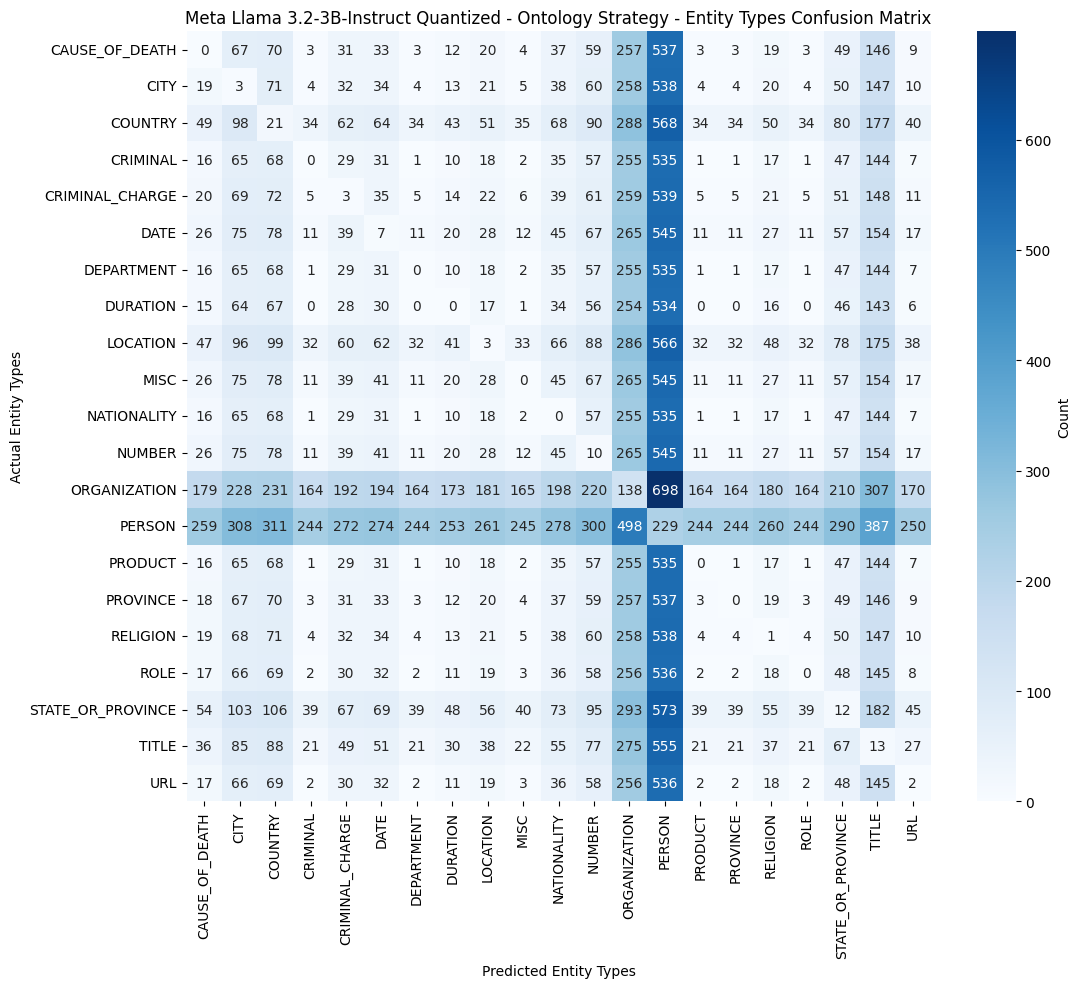

In [32]:
title = "Meta Llama 3.2-3B-Instruct Quantized - Ontology Strategy - Entity Types Confusion Matrix"

llama_ontology_confusion_matrix = create_entity_type_confusion_matrix(llama_3bq_ontology_cm_results_df)
plot_entity_type_confusion_matrix(llama_ontology_confusion_matrix, title=title)

### Meta Llama 3.2-3B-Instruct Quantized - Ontology Strategy - Relation Types

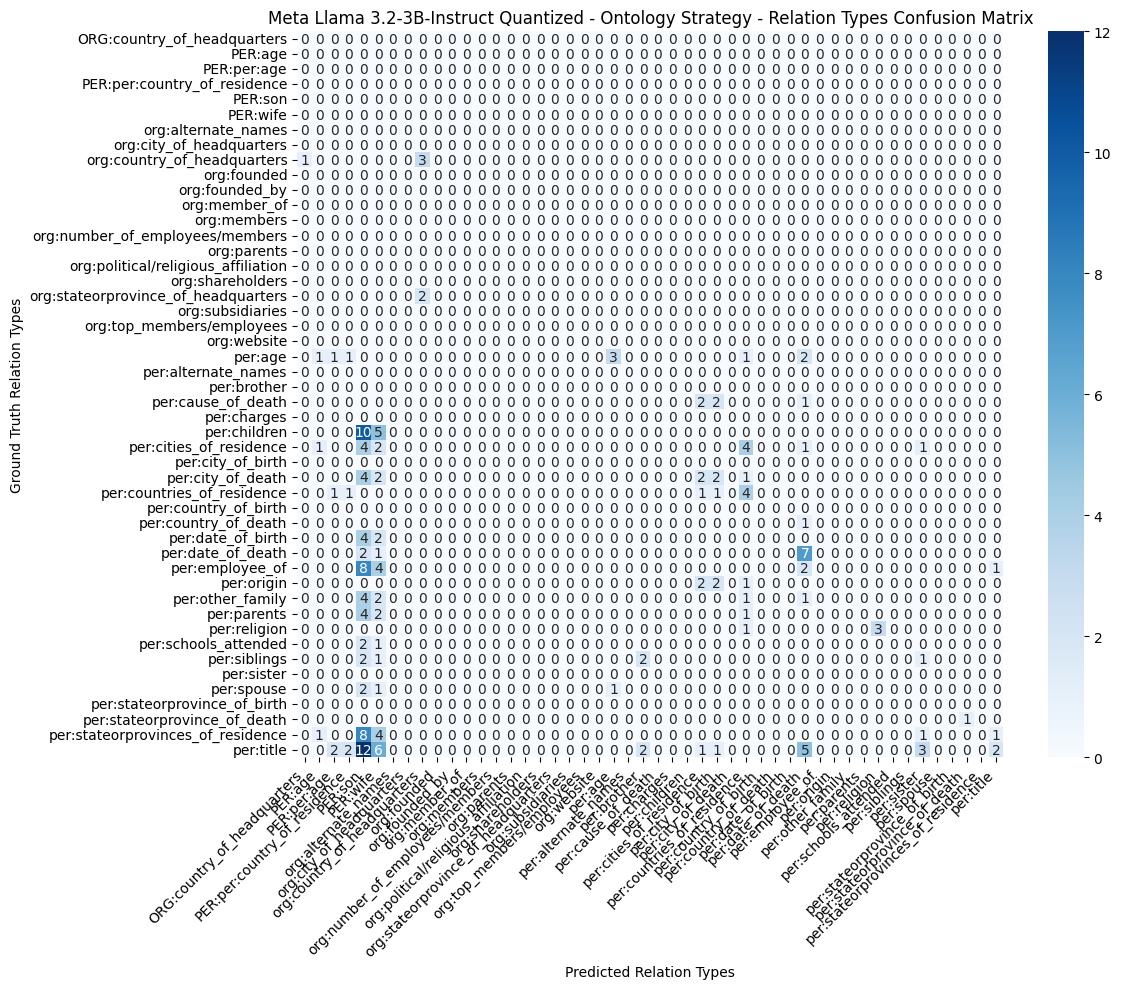

In [33]:
title = "Meta Llama 3.2-3B-Instruct Quantized - Ontology Strategy - Relation Types Confusion Matrix"

llama_ontology_confusion_matrix = create_relation_type_confusion_matrix(llama_3bq_ontology_cm_results_df)
plot_relation_type_confusion_matrix(llama_ontology_confusion_matrix, title=title)

## Entity & Relationship Type Metrics

### Function Definitions

In [34]:
%pip install tabulate


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [35]:
from tabulate import tabulate

In [36]:
import pandas as pd
from collections import Counter

def compute_entity_type_metrics(df):
    """
    Compute performance metrics (TP, FP, FN, Precision, Recall, F1) for each entity type.
    """
    # Counters for entity type-level metrics
    tp_counter = Counter()
    fp_counter = Counter()
    fn_counter = Counter()

    for _, row in df.iterrows():
        # Extract ground truth and predicted entity types
        gt_types = [entity[0] for entity in row['gt_entities']]
        pred_types = [entity[0] for entity in row['semantic_entity_matches']]

        gt_type_set = Counter(gt_types)
        pred_type_set = Counter(pred_types)

        # Compute True Positives (intersection of ground truth and predictions)
        for entity_type in gt_type_set:
            tp_counter[entity_type] += min(gt_type_set[entity_type], pred_type_set.get(entity_type, 0))
        
        # Compute False Positives (predicted but not in ground truth)
        for entity_type in pred_type_set:
            if entity_type not in gt_type_set:
                fp_counter[entity_type] += pred_type_set[entity_type]
            else:
                fp_counter[entity_type] += max(0, pred_type_set[entity_type] - gt_type_set[entity_type])

        # Compute False Negatives (ground truth but not predicted)
        for entity_type in gt_type_set:
            if entity_type not in pred_type_set:
                fn_counter[entity_type] += gt_type_set[entity_type]
            else:
                fn_counter[entity_type] += max(0, gt_type_set[entity_type] - pred_type_set[entity_type])

    # Compute precision, recall, and F1
    metrics = []
    all_types = set(tp_counter.keys()).union(fp_counter.keys()).union(fn_counter.keys())
    for entity_type in all_types:
        tp = tp_counter[entity_type]
        fp = fp_counter[entity_type]
        fn = fn_counter[entity_type]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        metrics.append({
            "Entity Type": entity_type,
            "True Positive (TP)": tp,
            "False Positive (FP)": fp,
            "False Negative (FN)": fn,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        })

    return pd.DataFrame(metrics)

In [37]:
import pandas as pd
from collections import Counter

def compute_relation_type_metrics(df):
    metrics = {}

    for _, row in df.iterrows():
        # Extract ground truth and predicted relation types
        gt_rel_types = [rel[0][1] for rel in row['gt_relationships']]  # Extract the relation type (e.g., 'per:age')
        pred_rel_types = [rel[0][1] for rel in row['semantic_relationship_matches']]  # Extract predicted relation type

        # Count occurrences of each relation type
        gt_rel_set = Counter(gt_rel_types)
        pred_rel_set = Counter(pred_rel_types)

        for rel_type in set(gt_rel_types + pred_rel_types):
            if rel_type not in metrics:
                metrics[rel_type] = {'TP': 0, 'FP': 0, 'FN': 0}

            # True Positives: Count of correctly predicted relations
            tp = min(gt_rel_set.get(rel_type, 0), pred_rel_set.get(rel_type, 0))
            metrics[rel_type]['TP'] += tp

            # False Positives: Predicted relations that don't match ground truth
            fp = pred_rel_set.get(rel_type, 0) - tp
            metrics[rel_type]['FP'] += fp

            # False Negatives: Ground truth relations that were not predicted
            fn = gt_rel_set.get(rel_type, 0) - tp
            metrics[rel_type]['FN'] += fn

    # Calculate Precision, Recall, and F1 Score
    for rel_type, counts in metrics.items():
        tp = counts['TP']
        fp = counts['FP']
        fn = counts['FN']
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
        counts['Precision'] = precision
        counts['Recall'] = recall
        counts['F1'] = f1

    # Convert metrics to DataFrame for better visualization
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index').reset_index()
    metrics_df.rename(columns={'index': 'Relation Type'}, inplace=True)

    return metrics_df

### Meta Llama 3.2-3B-Instruct - Ontology Strategy - Entity Type Metrics

In [38]:
# Compute metrics
llama_ontology_entity_metrics = compute_entity_type_metrics(llama_3b_ontology_cm_results_df)

# Generate a tabulated version of the DataFrame
table = tabulate(llama_ontology_entity_metrics, headers='keys', tablefmt='grid', showindex=False)

# Print the table
print(table)

+-------------------+----------------------+-----------------------+-----------------------+-------------+-----------+-----------+
| Entity Type       |   True Positive (TP) |   False Positive (FP) |   False Negative (FN) |   Precision |    Recall |        F1 |
+===================+======================+=======================+=======================+=============+===========+===========+
| DATE              |                    4 |                     1 |                    26 |    0.8      | 0.133333  | 0.228571  |
+-------------------+----------------------+-----------------------+-----------------------+-------------+-----------+-----------+
| CAUSE             |                    0 |                     1 |                     0 |    0        | 0         | 0         |
+-------------------+----------------------+-----------------------+-----------------------+-------------+-----------+-----------+
| PERSON            |                  224 |                     6 |               

### OpenAI GPT4 - CoT Strategy - Relationship Type Metrics

In [39]:
# Compute metrics
openai_cot_relationship_metrics = compute_relation_type_metrics(llama_3b_ontology_cm_results_df)

# Generate a tabulated version of the DataFrame
table = tabulate(openai_cot_relationship_metrics, headers='keys', tablefmt='grid', showindex=False)

# Print the table
print(table)

+-------------------------------------+------+------+------+-------------+-----------+-----------+
| Relation Type                       |   TP |   FP |   FN |   Precision |    Recall |        F1 |
+=====================================+======+======+======+=============+===========+===========+
| org:founded_by                      |    0 |    0 |    9 |         0   | 0         | 0         |
+-------------------------------------+------+------+------+-------------+-----------+-----------+
| per:stateorprovinces_of_residence   |    0 |    0 |   33 |         0   | 0         | 0         |
+-------------------------------------+------+------+------+-------------+-----------+-----------+
| per:charges                         |    2 |    0 |   27 |         1   | 0.0689655 | 0.129032  |
+-------------------------------------+------+------+------+-------------+-----------+-----------+
| per:countries_of_residence          |    1 |    0 |   52 |         1   | 0.0188679 | 0.037037  |
+---------

## Composite Bar Metrics

### Function Definitions

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_composite_bar_metric(title, name_df_pairs, metrics, log_scale=False):
    """
    Plots a composite bar chart for a list of (name, dataframe) pairs.

    Args:
        title (str): The title of the plot.
        name_df_pairs (list): A list of tuples (name, dataframe), where:
                              - name (str): Algorithm or model name.
                              - dataframe (pd.DataFrame): DataFrame containing the metrics.
        metrics (list): A list of metric names (str) to extract and plot from each DataFrame.
    """
    # Initialize variables for plotting
    n_groups = len(name_df_pairs)  # Number of clusters
    n_metrics = len(metrics)       # Number of bars per cluster
    index = np.arange(n_groups)    # Indices for clusters
    bar_width = 0.8 / n_metrics    # Width of each bar
    
    # Colors for metrics
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, n_metrics))
    # Set up the figure
    plt.figure(figsize=(10, 6))
    
    # Plot each metric as a separate bar in the cluster
    for i, metric in enumerate(metrics):
        values = [
            df[metric].mean() if metric in df.columns else 0  # Use mean or default 0
            for _, df in name_df_pairs
        ]
        plt.bar(index + i * bar_width, values, bar_width, label=metric, color=colors[i])
    
    # Set the x-ticks and labels
    plt.xticks(index + bar_width * (n_metrics - 1) / 2, [name for name, _ in name_df_pairs], rotation=20)
    plt.title(title)

    plt.ylabel("Metric Values")
    plt.legend(title="Metrics")

    # Apply logarithmic scale if specified
    if log_scale:
        plt.yscale('log')
        
    plt.tight_layout()
    plt.show()


### Composite Plots

In [41]:
print(llama_1bq_cot_cm_metrics_df)

   Entity Precision  Entity Recall  Entity F1  Relationship Precision  \
0          0.310595       0.162121   0.213041                     0.0   

   Relationship Recall  Relationship F1  Malformed Outputs  Invalid Entities  \
0                  0.0                0                 83               673   

   Invalid Relationships  average_prompt_time  
0                    559            15.690759  


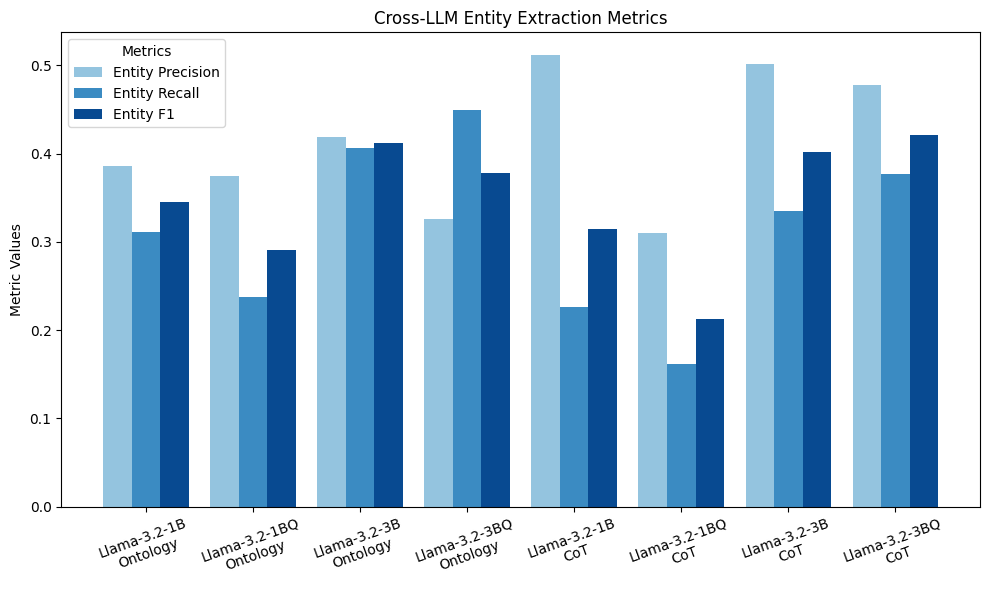

In [51]:
# Cross-LLM Entity Extraction Metrics

name_df_pairs = [
    ("Llama-3.2-1B\nOntology", llama_1b_ontology_cm_metrics_df),
    ("Llama-3.2-1BQ\nOntology", llama_1bq_ontology_cm_metrics_df),
    ("Llama-3.2-3B\nOntology", llama_3b_ontology_cm_metrics_df),
    ("Llama-3.2-3BQ\nOntology", llama_3bq_ontology_cm_metrics_df),
    ("Llama-3.2-1B\nCoT", llama_1b_cot_cm_metrics_df),
    ("Llama-3.2-1BQ\nCoT", llama_1bq_cot_cm_metrics_df),
    ("Llama-3.2-3B\nCoT", llama_3b_cot_cm_metrics_df),    
    ("Llama-3.2-3BQ\nCoT", llama_3bq_cot_cm_metrics_df),   
]

# List of metrics to visualize
metrics = ["Entity Precision", "Entity Recall", "Entity F1"]

# Call the function
plot_composite_bar_metric("Cross-LLM Entity Extraction Metrics", name_df_pairs, metrics)

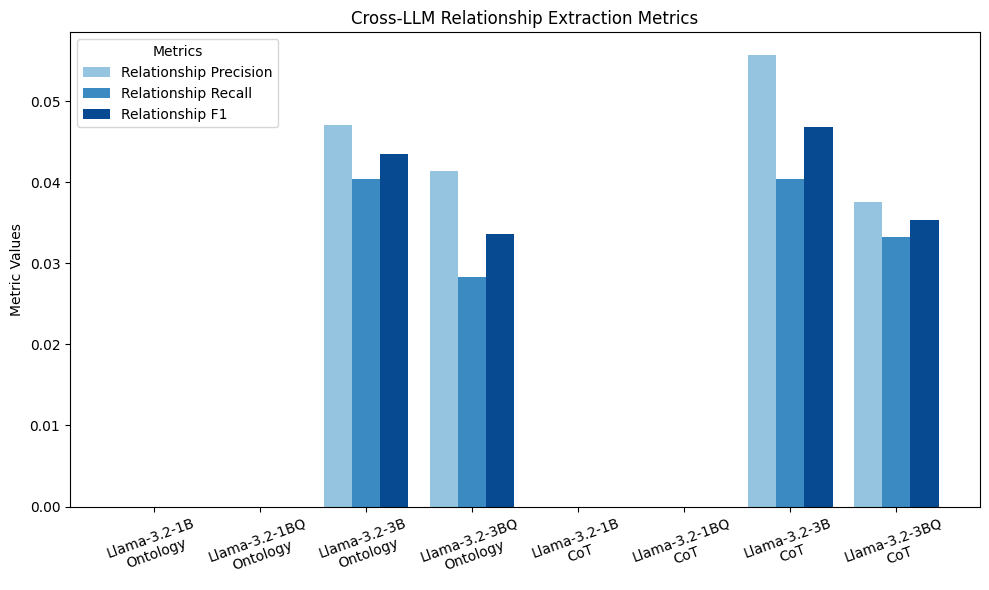

In [50]:
# Cross-LLM Relationship Extraction Metrics

name_df_pairs = [
    ("Llama-3.2-1B\nOntology", llama_1b_ontology_cm_metrics_df),
    ("Llama-3.2-1BQ\nOntology", llama_1bq_ontology_cm_metrics_df),
    ("Llama-3.2-3B\nOntology", llama_3b_ontology_cm_metrics_df),
    ("Llama-3.2-3BQ\nOntology", llama_3bq_ontology_cm_metrics_df),
    ("Llama-3.2-1B\nCoT", llama_1b_cot_cm_metrics_df),
    ("Llama-3.2-1BQ\nCoT", llama_1bq_cot_cm_metrics_df),
    ("Llama-3.2-3B\nCoT", llama_3b_cot_cm_metrics_df),    
    ("Llama-3.2-3BQ\nCoT", llama_3bq_cot_cm_metrics_df),   
]

# List of metrics to visualize
metrics = ["Relationship Precision", "Relationship Recall", "Relationship F1"]

# Call the function
plot_composite_bar_metric("Cross-LLM Relationship Extraction Metrics", name_df_pairs, metrics)

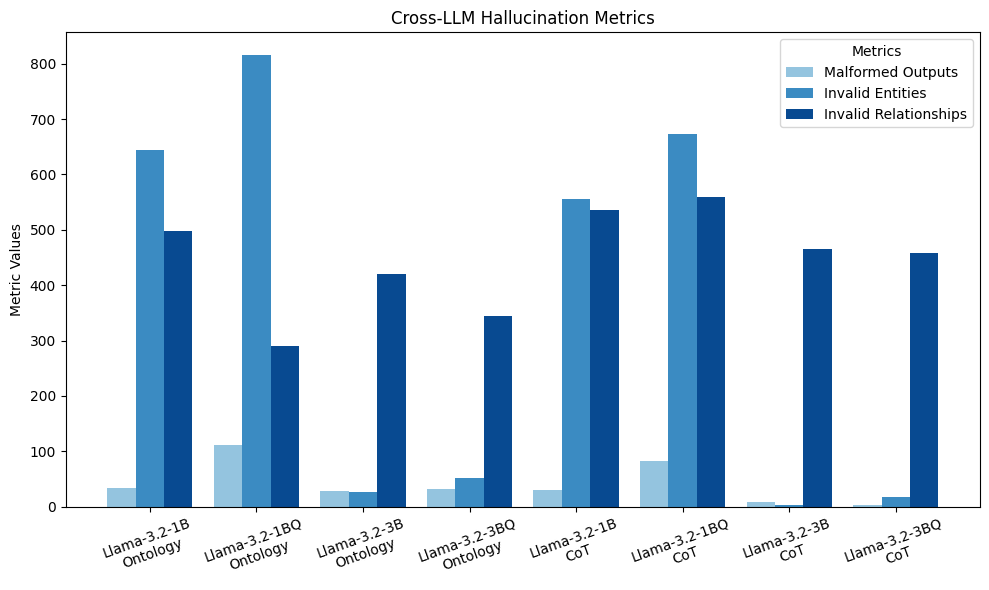

In [52]:
# Cross-LLM Relationshipt Extraction Metrics

name_df_pairs = [
    ("Llama-3.2-1B\nOntology", llama_1b_ontology_cm_metrics_df),
    ("Llama-3.2-1BQ\nOntology", llama_1bq_ontology_cm_metrics_df),
    ("Llama-3.2-3B\nOntology", llama_3b_ontology_cm_metrics_df),
    ("Llama-3.2-3BQ\nOntology", llama_3bq_ontology_cm_metrics_df),
    ("Llama-3.2-1B\nCoT", llama_1b_cot_cm_metrics_df),
    ("Llama-3.2-1BQ\nCoT", llama_1bq_cot_cm_metrics_df),
    ("Llama-3.2-3B\nCoT", llama_3b_cot_cm_metrics_df),    
    ("Llama-3.2-3BQ\nCoT", llama_3bq_cot_cm_metrics_df),   
]

# List of metrics to visualize
metrics = ["Malformed Outputs", "Invalid Entities", "Invalid Relationships"]

# Call the function
plot_composite_bar_metric("Cross-LLM Hallucination Metrics", name_df_pairs, metrics)

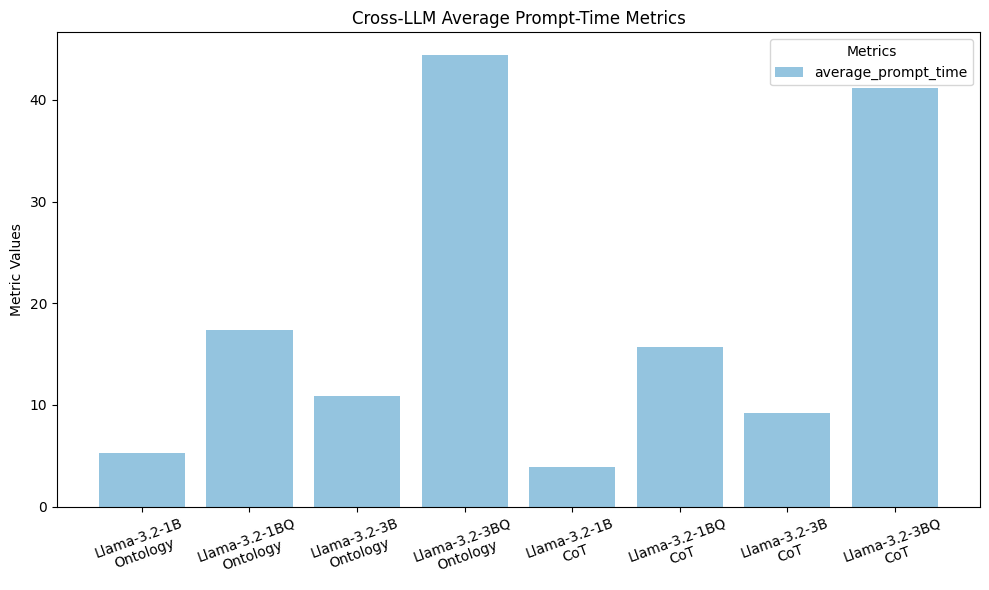

In [47]:
# Cross-LLM Average Prompt Time Metrics

name_df_pairs = [
    ("Llama-3.2-1B\nOntology", llama_1b_ontology_cm_metrics_df),
    ("Llama-3.2-1BQ\nOntology", llama_1bq_ontology_cm_metrics_df),
    ("Llama-3.2-3B\nOntology", llama_3b_ontology_cm_metrics_df),
    ("Llama-3.2-3BQ\nOntology", llama_3bq_ontology_cm_metrics_df),
    ("Llama-3.2-1B\nCoT", llama_1b_cot_cm_metrics_df),
    ("Llama-3.2-1BQ\nCoT", llama_1bq_cot_cm_metrics_df),
    ("Llama-3.2-3B\nCoT", llama_3b_cot_cm_metrics_df),    
    ("Llama-3.2-3BQ\nCoT", llama_3bq_cot_cm_metrics_df),   
]

# List of metrics to visualize
metrics = ["average_prompt_time"]

# Call the function
plot_composite_bar_metric("Cross-LLM Average Prompt-Time Metrics", name_df_pairs, metrics)

## GPU Memory Measurement

In [1]:
%pip install pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 8.7 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import time
import pandas as pd
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlShutdown

def monitor_models_to_dataframe(models, interval=60, duration=3600, output_file="gpu_model_memory_usage.pkl"):
    """
    Monitors GPU memory usage for specified models and GPUs, storing stats in a DataFrame.
    
    Args:
        models (list of tuples): Each tuple specifies (model_name, gpu_id).
        interval (int): Time in seconds between each check.
        duration (int): Total monitoring duration in seconds.
        output_file (str): File path to save the DataFrame as a .pkl file.
    """
    nvmlInit()
    start_time = time.time()
    end_time = start_time + duration

    # Initialize a dictionary to store memory usage lists for each (model_name, gpu_id) pair
    stats = {model_name: {"gpu_id": gpu_id, "memory_usage_mb": []} for model_name, gpu_id in models}

    try:
        while time.time() < end_time:
            for model_name, gpu_id in models:
                handle = nvmlDeviceGetHandleByIndex(gpu_id)
                info = nvmlDeviceGetMemoryInfo(handle)
                used_memory_mb = info.used / 1024 ** 2
                stats[model_name]["memory_usage_mb"].append(used_memory_mb)
            time.sleep(interval)
    finally:
        nvmlShutdown()

    # Convert stats to a DataFrame
    rows = []
    for model_name, data in stats.items():
        rows.append({
            "model_name": model_name,
            "gpu_id": data["gpu_id"],
            "memory_usage_mb": data["memory_usage_mb"]
        })

    df = pd.DataFrame(rows)
    df.to_pickle(output_file)
    print(f"GPU memory stats saved to {output_file}")

In [3]:
models = [
    ("Llama3.2-3B-Cot", 0)
]

monitor_models_to_dataframe(models, interval=60, duration=700, output_file="./output/llama-3.2-cot-memory-results-3B-only-final-gold-1")

GPU memory stats saved to ./output/llama-3.2-cot-memory-results-3B-only-final-gold-1


In [4]:
import pandas as pd

ontology_memory_results_df = pd.read_pickle("./output/llama-3.2-cot-memory-results-3B-only-final-gold-1")
print(ontology_memory_results_df) 

        model_name  gpu_id                                    memory_usage_mb
0  Llama3.2-3B-Cot       0  [9468.625, 12148.625, 12720.625, 12720.625, 12...
